# Quality control, Filtering, and Clustering of Single-cell RNA data

## Introduction

Here we will take a hands-on approach and start with some of the first steps when working with single cell RNA sequencing data, in this case from the 10X platform.

## Data
We will be using publicly available data from the 'gut cell atlas', starting after the raw reads are converted into per-cell transcript counts via the 10X platform software. That earlier step (raw reads to the matrix) is done in a completely automated manner. It is interesting in and of itself (particularly when your experiment requires detection of non-standard genes, like transgenes or viral transcripts during an infection experiment). But we will start one step after that one, where things are decidedly less automated.

## Objective
For CD45+ preselected fraction cells, identify the cell types present.

## Learning Objectives
- Become familiar with accessing data via code
- Become familiar with 'big data' stored in the anndata format.
- Become familiar with filtering data via slicing of matricies.
- Get hands-on experience with the nuances of processing single cell data, including aspects that have subjective components.


In [1]:
# Get rid of some notifications more related to things that are changing in the underlying libraries. Good to know but noise for now.
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Loading libraries

Python has a robust system of libraries and dependency checking. In the following blocks we will be loading a bunch of libraries so we can work with our data.

### Data science libraries
- `anndada` is a library for loading the raw data. It can handle data stored in a bunch of different ways, but here we will use data in the `h5ad` format that is fast (even for huge datasets), helps us keep track of the metadata (which patient, body site, outcome, etc) and information about the features (e.g., the gene names, splice variants, etc). This is a much more powerful format than excel or CSV. `h5ad` files can be opened in python and R.
- `pandas` is the adorably-named python data analysis library. Roughly equivalent to `dylpr` in R, it is an incredibly powerful system for handling data in dataframes. It can handle both data in `wide` and `long` format, supports very quick slicing, dicing, grouping, and summarizing of data--all things we will need to do.
- `scanpy` is the python single-cell sequencing data analysis library. It helps us do a bunch of things we will need to do to achieve our goal here today.
- `numpy` is the Python numerical library. It is a super powerful library to do math things, like log-transformations.

In [2]:
import anndata as ad
import pandas as pd
import scanpy as sc
import numpy as np

### Statistical libraries

- `scipy` is the python 'science' library, filled with useful basic stastical tools (eg., t-test, odds-ratio calculators, etc.)
- `statsmodels` contains a ton of useful regression, prediction, and other statistical tools all nicely with a standardized interface.

In [3]:
import scipy
import statsmodels.api as sm

### Gene set enrichment library

- `gseapy` is a nice library that can use publicly available gene set enrichment tools. "Which cells have these genes expressed?" "What does this gene do?"

In [4]:
import gseapy as gp

### Graphing and figure libraries

These two libaries combined are roughly equivalent to what `ggplot` can do in R
- `matplotlib` is the more basic plotting library, able to make a variety of basic plot types (scatter, line, bar, errorbar, etc.)
- `seaborn` is built upon matplotlib, and can make more sophisticated plots (swarm, strip, violin, heatmap, clustermap, etc.)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# Set a few parameters for the scanpy library
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.8 anndata==0.10.5 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.11.3 pynndescent==0.5.11


***Comment:*** 

One nice thing here is the printing out of the versions of all the libraries being used. This is key if one wishes to try to reproduce the analysis in the future. Libraries do change over time, in how you use them (the interface) and how they do the same task (the implementation). Both can make it hard in the future (years later) to redo an analysis. 

Here we know the exact versions used when we ran *this* analysis. That's a huge help to future you.

### Load the *data*

The data is stored in the [h5ad](https://anndata.readthedocs.io/en/latest/) format. 

This is a neat format that keeps track of both the data (the 'this cell had this many reads mapping to that gene' counts) and the key metadata ('where did this cell come from?' and 'was this gene mitochondrial or not?') as well as all of the analysis outputs. It also loads very quickly.

If you tried to load the equivalent data in Excel format (41650 rows and 22164 columns), Excel would struggle and likely crash after a long time (depending on how much memory you have available). 

In [7]:
cca = ad.read_h5ad(
    'data/Colon_cell_atlas.clean.h5ad'
)
cca

AnnData object with n_obs × n_vars = 41650 × 22164
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito'
    var: 'MT'

`cca` represents the anndata object. 

You can think about it like the start of an address or telephone number. To get to things like the data, metadata, or analysis, you have to walk down from the start (`cca`) to the location within you want to go, with each step separated by a `.`:

For example, let's look at a teeny bit of the count data, which is stored for now in `cca.X`:

In [8]:
cca.X

<41650x22164 sparse matrix of type '<class 'numpy.int32'>'
	with 57752072 stored elements in Compressed Sparse Row format>

The data is stored as `sparse` data. It's mostly zeros, so only the parts with some value are actually stored. The zeros are otherwise implied. This makes it much more efficient in memory. Still, the data is there, zeros and all, and can be converted to `dense` format (what you have seen in spreadsheets all the time). Let's look at the first five rows (cells) and first five columns (genes) to see the raw count data stored within:

In [9]:
cca.X[
    5:10,
    5:10,
].todense()

matrix([[1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=int32)

## Metadata

### OBS
`obs` is a `pandas` `dataframe` that contains the metadata details for each observation, or cell for single-cell datasets. 
It's a big table, where each cell gets a row, and then one can add on colums with information about that cell.
Each column can contain one kind of information (numbers, words, etc.).
This is `wide` formatted data, and pretty strict. Each and every cell must have something directly assigned to it.


In [10]:
cca.obs.head()

Fraction         batch donor  gender  region  \
index                                                                          
AAACGGGAGGTGCAAC-1-Pan_T7935487    Total  Pan_T7935487  390c  Female  Caecum   
AAAGATGTCCTCAACC-1-Pan_T7935487    Total  Pan_T7935487  390c  Female  Caecum   
AAAGTAGTCTTACCGC-1-Pan_T7935487    Total  Pan_T7935487  390c  Female  Caecum   
AACCATGCAGATTGCT-1-Pan_T7935487    Total  Pan_T7935487  390c  Female  Caecum   
AACCATGTCCTGCCAT-1-Pan_T7935487    Total  Pan_T7935487  390c  Female  Caecum   

                                 n_counts  percent_mito  
index                                                    
AAACGGGAGGTGCAAC-1-Pan_T7935487   33377.0      0.016568  
AAAGATGTCCTCAACC-1-Pan_T7935487   25783.0      0.024396  
AAAGTAGTCTTACCGC-1-Pan_T7935487   31618.0      0.023721  
AACCATGCAGATTGCT-1-Pan_T7935487   38287.0      0.020033  
AACCATGTCCTGCCAT-1-Pan_T7935487    6403.0      0.035608

#### Summarizing metadata
`pandas dataframes` have ways of summarizing data. 

Let's use some of these tools to find out how many cells (observations) per each value in these `obs` columns.
For example, how many cells to each `Fraction`:

In [11]:
cca.obs.Fraction.value_counts()

Fraction
CD45P    24907
CD4P     13444
Total     3299
Name: count, dtype: int64

batch:

In [12]:
cca.obs.batch.value_counts()

batch
4861STDY7135914           3129
4861STDY7135912           2986
4861STDY7135913           2975
Pan_T7935494              2717
4861STDY7135916           2510
4861STDY7208417           2380
4861STDY7135918           2375
4861STDY7135911           2233
4861STDY7208411           1999
Human_colon_16S7255682    1944
4861STDY7208410           1530
4861STDY7208416           1386
Human_colon_16S7255676    1268
4861STDY7208415           1217
4861STDY7208413           1209
4861STDY7135917           1179
4861STDY7208412           1117
Human_colon_16S7255678    1094
Human_colon_16S8000484    1071
Human_colon_16S7255681     915
4861STDY7135915            861
Human_colon_16S7255680     807
Human_colon_16S7255677     646
Human_colon_16S8001871     599
4861STDY7208414            365
Pan_T7935487               251
Human_colon_16S8001867     235
Pan_T7935488               213
Human_colon_16S7255675     127
Pan_T7935489               118
Human_colon_16S7255679     110
Human_colon_16S8001863      84
Na

##### donor:

In [13]:
cca.obs.donor.value_counts()

donor
290b    18248
298c    11203
302c     6911
390c     3299
417c     1989
Name: count, dtype: int64

##### gender:

In [14]:
cca.obs.gender.value_counts()

gender
Female    21547
Male      20103
Name: count, dtype: int64

##### Region:

In [15]:
cca.obs.region.value_counts()

region
mLN           13958
Transverse    10627
Caecum        10478
Sigmoid        6587
Name: count, dtype: int64

`pandas` `dataframes` can also do this same trick but for multiple columns at once via `groupby`.

In this case counting up how many cells in each anatomic region and fraction:


In [16]:
cca.obs.groupby([
    'region',
    'Fraction'
]).count()

batch  donor  gender  n_counts  percent_mito
region     Fraction                                              
Caecum     CD4P       3890   3890    3890      3890          3890
           CD45P      6337   6337    6337      6337          6337
           Total       251    251     251       251           251
Sigmoid    CD4P       1336   1336    1336      1336          1336
           CD45P      5133   5133    5133      5133          5133
           Total       118    118     118       118           118
Transverse CD4P       3480   3480    3480      3480          3480
           CD45P      6934   6934    6934      6934          6934
           Total       213    213     213       213           213
mLN        CD4P       4738   4738    4738      4738          4738
           CD45P      6503   6503    6503      6503          6503
           Total      2717   2717    2717      2717          2717

## CD45 Pos cells

Let's now focus in on the cells pre-selected to be CD45 positive.

To do so, we will use something called slicing:
We will use the `Fraction` column in th e`obs` (per-cell metadata) stored in the `cca` anndata object to only keep the rows that have a `Fraction` value equal to (`==`) `CD45P`.

Our earlier `value_counts` helped us figure out exactly how we needed to do this.

In [17]:
cca[
    cca.obs.Fraction == 'CD45P'
]

View of AnnData object with n_obs × n_vars = 24907 × 22164
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito'
    var: 'MT'

`Slicing` is 'lazy' by default: it quickly narrows down to the rows we want, but doesn't copy the original data. Instead it just refers back to the original whole dataset. This makes it super quick and efficient... but not great if we want to *modify* the subset of data (CD45 positive cells), so let's go on to copy the subset into a new dataset (another anndata) so we can modify it and not worry about affecting the original data.

In [18]:
cca_l = cca[
    cca.obs.Fraction == 'CD45P'
].copy()
cca_l

AnnData object with n_obs × n_vars = 24907 × 22164
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito'
    var: 'MT'

Just within the CD45+ lymphocyte subset (housed in `cca_l`), let's find the highest expressed genes and look at them. 
To do so, we will use the `scanpy` libraries that have much of the analysis we need to do implemented cleanly in one-step functions:


normalizing counts per cell
    finished (0:00:00)


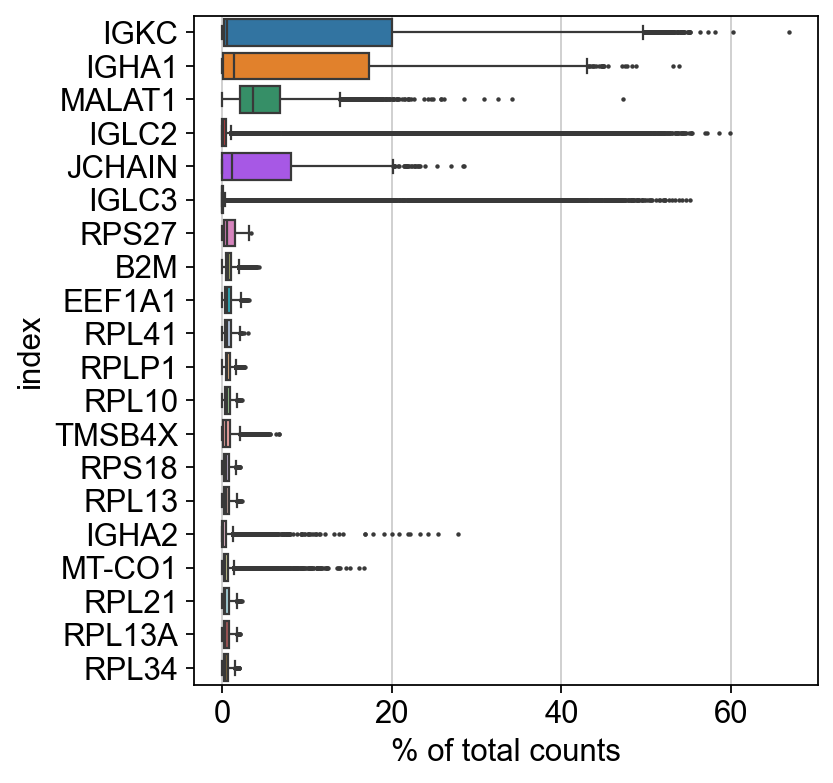

In [19]:
sc.pl.highest_expr_genes(
    cca_l, 
    n_top=20, 
)

- IGKC: Immune gobulin kappa light subunit
- IGHA1: Immune globulin heavy chain alpha subunit (invariate)
- JCGAIN: Joining (J) chain, key for secretion of IgA / IgM.

### Pre-Filtering
Very conservative step to get rid of noise / junk / clearly failed observations.

Let's get rid of (in this subset):
- Cells with very few genes with any level of transcripts (likely dead / dying, incomplete cells)
- Get rid of genes rarely if ever expressed in these cells (minimum of three cells).

This uses two `scanpy` convenience functions that *change the anndata object* in place. I.e., after running these the dataset is modified, and we will need to reload or remake to go back from this step

In [20]:
# Filtering
sc.pp.filter_cells(cca_l, min_genes=200)
sc.pp.filter_genes(cca_l, min_cells=3)
cca_l

filtered out 5248 genes that are detected in less than 3 cells


AnnData object with n_obs × n_vars = 24907 × 16916
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes'
    var: 'MT', 'n_cells'

### Filtering

We will use `scanpy` to calculate some per cell metrics to further filter down to the cells most likely to represent good data.

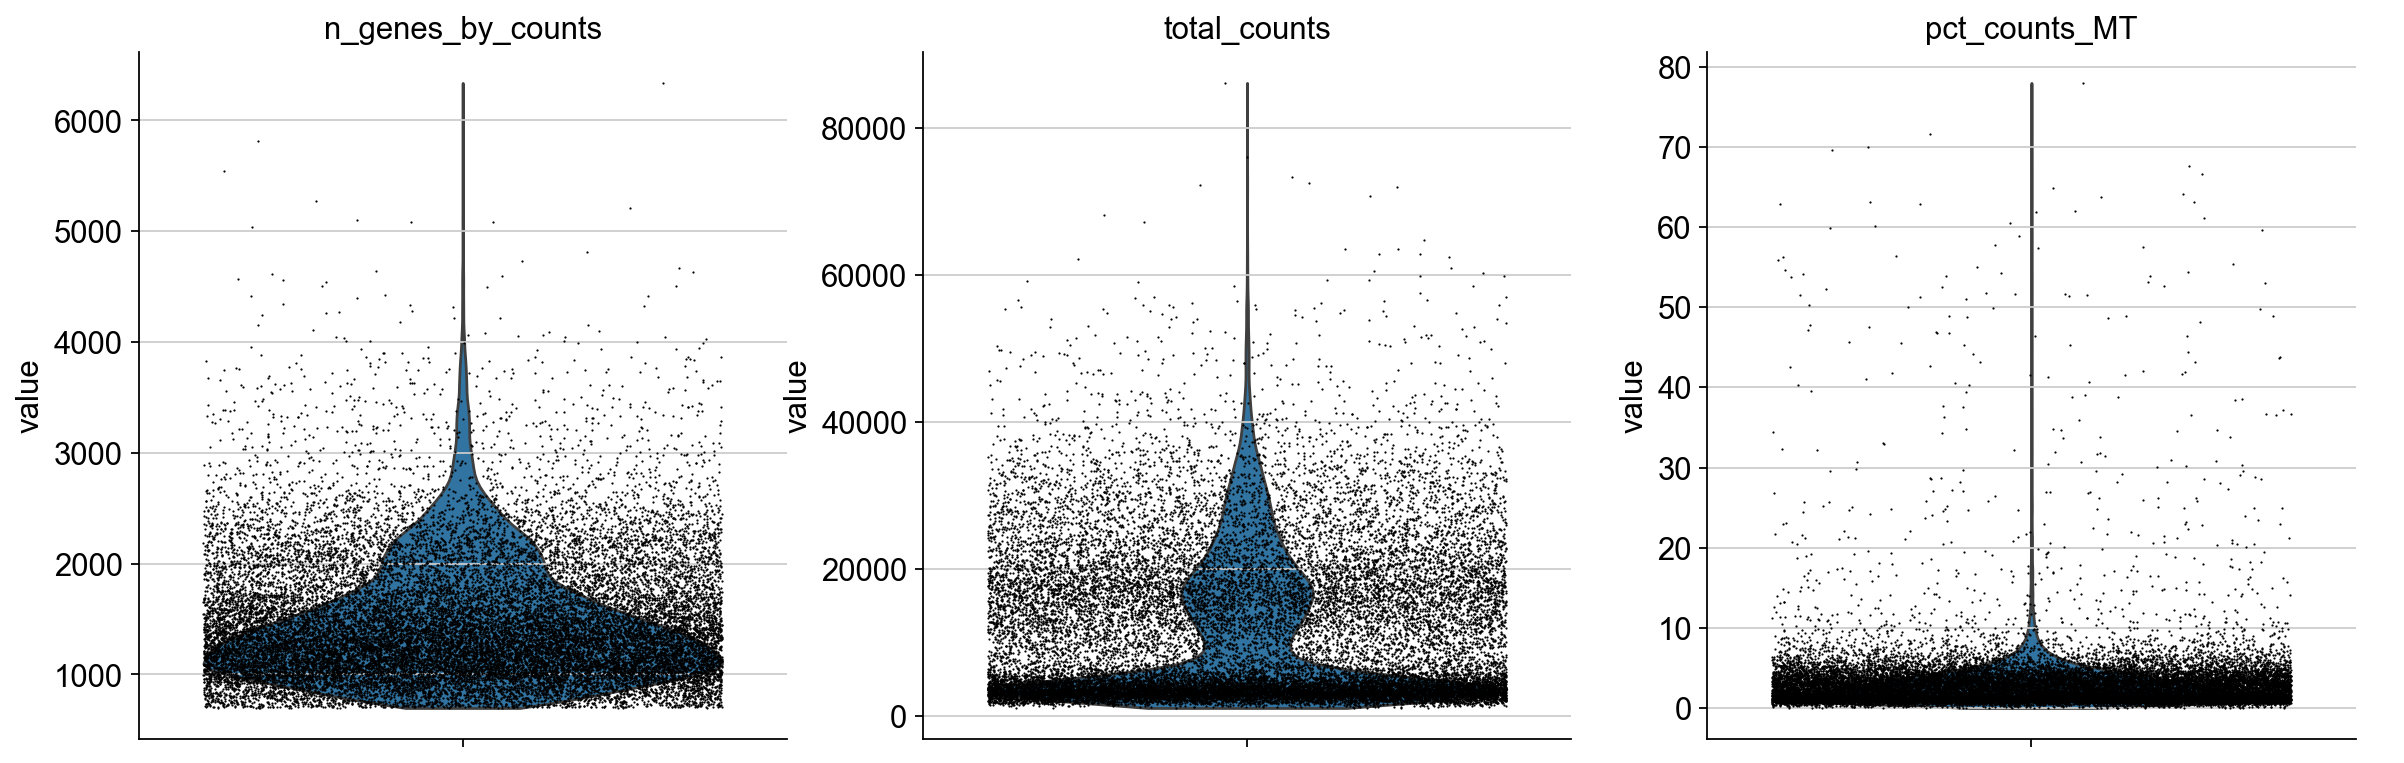

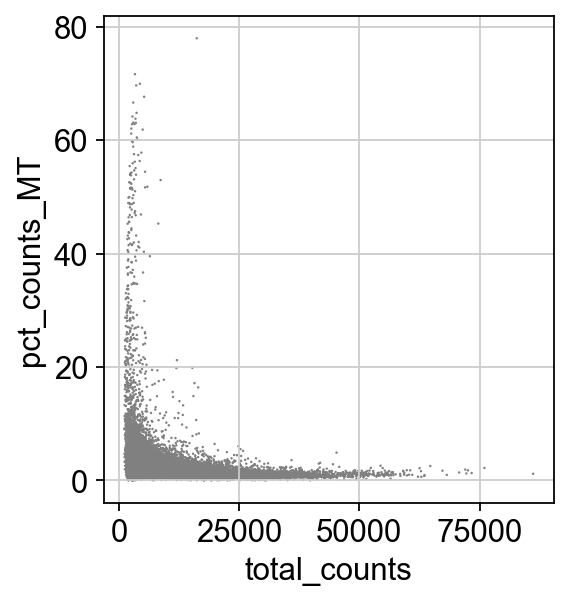

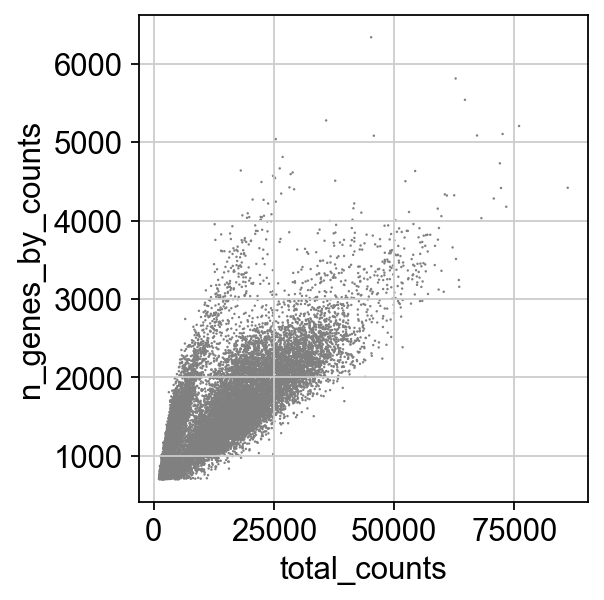

In [21]:
sc.pp.calculate_qc_metrics(
    cca_l, 
    qc_vars=['MT'], 
    percent_top=None, 
    log1p=False,
    inplace=True
)
# And plot
sc.pl.violin(
    cca_l,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=True
)

sc.pl.scatter(
    cca_l, 
    x='total_counts', 
    y='pct_counts_MT'
)
sc.pl.scatter(
    cca_l,
    x='total_counts', 
    y='n_genes_by_counts'
)

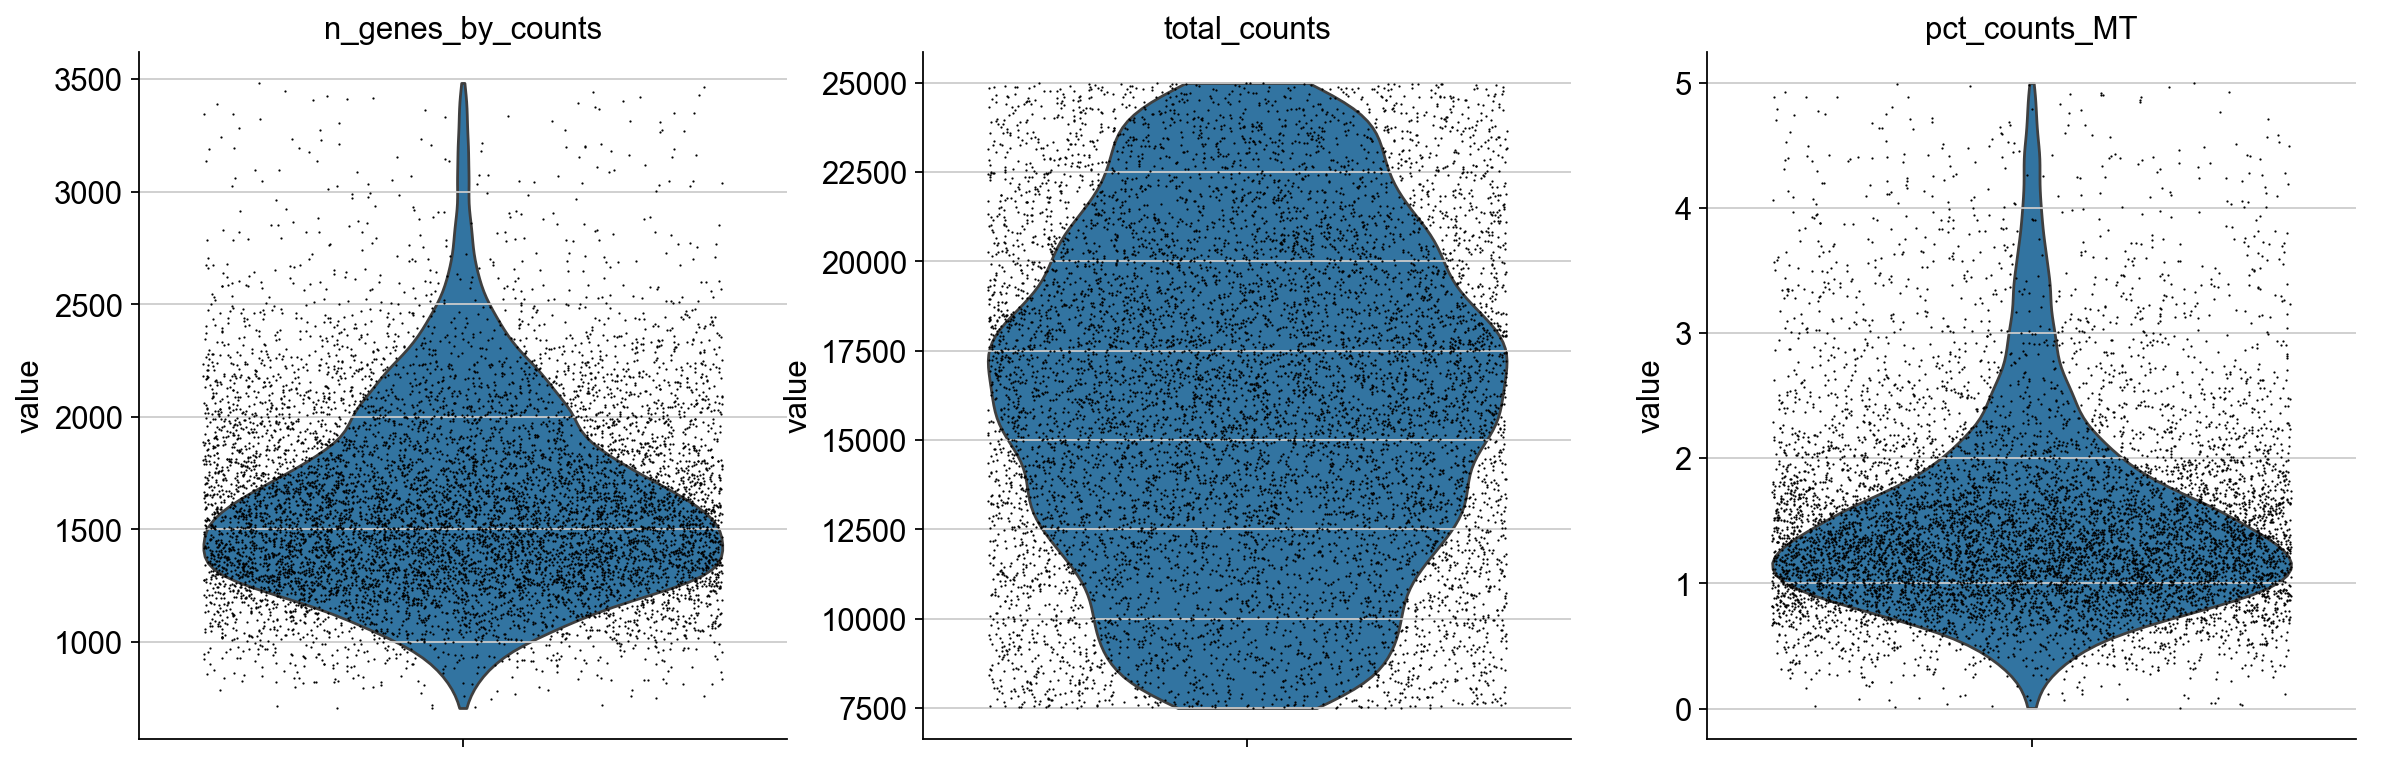

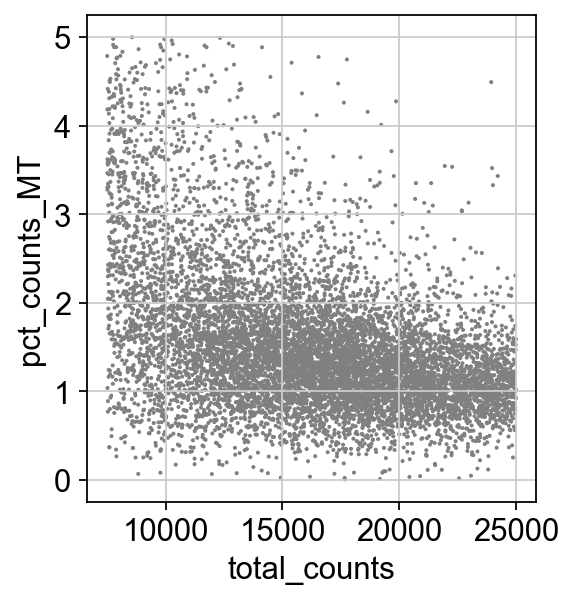

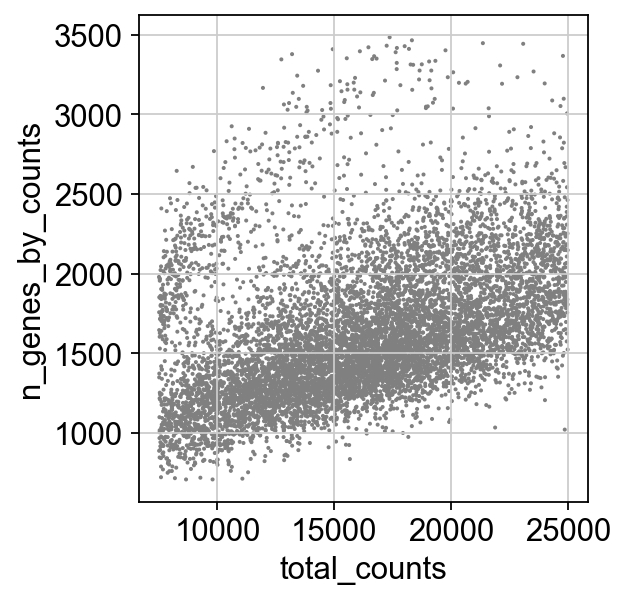

AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [22]:
# Filter
cca_l_filt = cca_l[
    (cca_l.obs.total_counts > 7500) &
    (cca_l.obs.total_counts < 25000) &
    (cca_l.obs.n_genes_by_counts < 3500) &
    (cca_l.obs.pct_counts_MT < 5),
    ~cca_l.var.MT
].copy()
# .. and view the results.
sc.pl.violin(
    cca_l_filt,
    ['n_genes_by_counts', 'total_counts', 'pct_counts_MT'],
    jitter=0.4,
    multi_panel=True
)
sc.pl.scatter(
    cca_l_filt, 
    x='total_counts', 
    y='pct_counts_MT'
)
sc.pl.scatter(
    cca_l_filt,
    x='total_counts', 
    y='n_genes_by_counts'
)
cca_l_filt

### Transformation of the count data

Now that we have filtered our cells and genes down to those most relevant for our analysis, let's transform our data from raw counts to depth normalized counts (`10K` or reads per 10,000 reads), and log-transformed depth-normalized counts after zero inflation.

One neat thing with anndata is we can have more than one matrix stored of the same cells-genes, kept as `layers`. So, we will have our log-transformed data in the `.X` address, but keep the raw counts, and depth-normalized counts in layers for future use. All is kept together, in the same order, sliced and filtered together, etc. 

In [23]:
# Store the raw counts for later use...
cca_l_filt.layers['raw_count'] = cca_l_filt.X.copy() 
# Normalize to 10k per specimen
sc.pp.normalize_total(cca_l_filt, target_sum=1e4)
cca_l_filt.layers['10K'] = cca_l_filt.X.copy()
# Logarithmize
sc.pp.log1p(cca_l_filt)

cca_l_filt


normalizing counts per cell
    finished (0:00:00)


AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'log1p'
    layers: 'raw_count', '10K'

In [24]:
# Log transformed ...
cca_l_filt.X[
    5:10,
    5:10
].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.34094283],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.6596192 , 0.        , 0.        , 0.        ]],
       dtype=float32)

In [25]:
# ... from reads per 10,000 reads ... 
cca_l_filt.layers['10K'][
    5:10,
    5:10
].todense()

matrix([[0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.40627286],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.9340557 , 0.        , 0.        , 0.        ]],
       dtype=float32)

In [26]:
# ... in turn derived from the actual observed raw counts.
cca_l_filt.layers['raw_count'][
    5:10,
    5:10
].todense()

matrix([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=int32)

### Dimensionality reduction.

We still have more genes than we have cells. This is not great from a statistical perspective. So, let's use a dimensionality reduction technique to narrow down to the subset of genes that remain biologically meaningful and can tell us the story of the data.

One way to do this is by finding 'highly variable genes', or genes whose normalized dispersion / deviation are high, are expressed at a decent level in the cells. `scanpy` provides a neat little function to do just that.


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


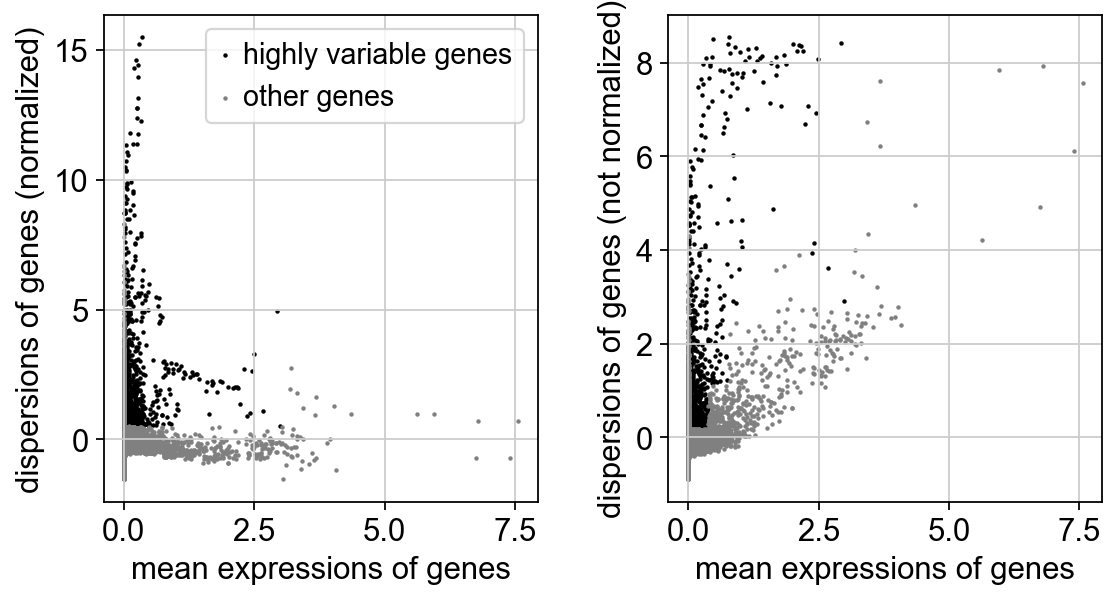

In [27]:
## Find 'highly variable genes'
sc.pp.highly_variable_genes(
    cca_l_filt, 
    min_mean=0.0125, 
    max_mean=3, 
    min_disp=0.5
)
sc.pl.highly_variable_genes(
    cca_l_filt
)


#### Anndata objects store analysis too!
All of the data (including the layers of raw data) and metadata remain, but now as we have done analyses, the results of the analysis are also added into addresses within the overall anndata object.

In [28]:
cca_l_filt

AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_count', '10K'

In [29]:
cca_l_filt.uns['hvg']

{'flavor': 'seurat'}

#### Another way to cache things as they are before filtering..

Anndata objects have a special `.raw` address where you can put things as the are before clicing down.


In [30]:
# Cache this state for later (before we filter down to only the highly variable)

cca_l_filt.raw = cca_l_filt
cca_l_filt

AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_count', '10K'

In [31]:
# Still, we will make a copy as well just to make the later steps easier. Even the copies are quick.
cca_l_filt_hv = cca_l_filt[
    :,
    cca_l_filt.var.highly_variable
].copy()
cca_l_filt_hv

AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_count', '10K'

In [32]:
# Let's make another layer, this time to store the un-regressed log transformed data...
cca_l_filt_hv.layers['log1p'] = cca_l_filt_hv.X

In [33]:
# regress out total reads  and pct mitochondiria

sc.pp.regress_out(
    cca_l_filt_hv, 
    ['total_counts', 'pct_counts_MT']
)
cca_l_filt_hv

regressing out ['total_counts', 'pct_counts_MT']
    sparse input is densified and may lead to high memory use
    finished (0:00:04)


AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'
    layers: 'raw_count', '10K', 'log1p'

In [34]:
cca_l_filt_hv.layers['log1p'][
    5:10,
    5:10,
].todense()

matrix([[0.4591213 , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 1.2235496 , 0.        , 0.        , 0.        ],
        [0.34094283, 0.        , 0.        , 0.        , 0.        ],
        [0.545932  , 0.545932  , 0.        , 0.        , 0.        ],
        [0.        , 0.6596192 , 0.        , 0.        , 0.        ]],
       dtype=float32)

In [35]:
cca_l_filt_hv.X[
    5:10,
    5:10,
]

array([[ 0.3940102 , -0.23447531, -0.02985208, -0.02611845, -0.02839008],
       [-0.1860779 ,  0.7306378 , -0.17953673, -0.15770279, -0.16638929],
       [ 0.29814956, -0.20111993, -0.0169037 , -0.01682591, -0.01913976],
       [ 0.4606151 ,  0.27301076, -0.05001954, -0.0431582 , -0.04609728],
       [-0.08985586,  0.3838258 , -0.04864773, -0.04095647, -0.04355226]],
      dtype=float32)

This sort of regression is 'standard' for single cell data. But do note, there are no more zeros! MOST of the data before this were zeros, and all now have a value. This has some advantages from statistical perspective, but is a bit of conjuring data from air. One reason to be weary of single-cell data analysis and double / triple check results. 

In [36]:
# Scale each gene to unit variance. Clip values exceeding standard deviation 10.
sc.pp.scale(
    cca_l_filt_hv, 
    max_value=10
)
cca_l_filt_hv

AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'raw_count', '10K', 'log1p'

In [37]:
cca_l_filt_hv.X[
    5:10,
    5:10,
]

array([[ 1.8810526 , -0.66534716, -0.10510725, -0.09688219, -0.10243628],
       [-0.88835853,  2.0732577 , -0.6321373 , -0.5849732 , -0.60036105],
       [ 1.4234023 , -0.5706979 , -0.05951685, -0.06241301, -0.06905954],
       [ 2.1990325 ,  0.77469534, -0.17611559, -0.16008843, -0.1663269 ],
       [-0.42898282,  1.0891441 , -0.17128552, -0.15192144, -0.15714401]],
      dtype=float32)

In [38]:
cca_l_filt_hv.layers['raw_count'][
    5:10,
    5:10,
].todense()

matrix([[1, 0, 0, 0, 0],
        [0, 2, 0, 0, 0],
        [1, 0, 0, 0, 0],
        [1, 1, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=int32)

Again to emphasize that after all the transformations, scaling, and regressions that have occurred our data looks quite different from the raw counts where we started. This is as 'standard' of a single cell analysis as one can do. It is worth actively contemplating how this fits within your understanding of biology and the questions you wish to answer...


### Ordination and clustering to identify groups of cells.

Single-cell based techniques are theoretically better able to capture the biology of mixed populations of cells--such as the CD45+ gut lymphocytes with which we are currently working. The typical process to identify which cell types are present is based upon ordination and clustering on the transformed and 'highly variable' genes, starting first with PCA:

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:29)


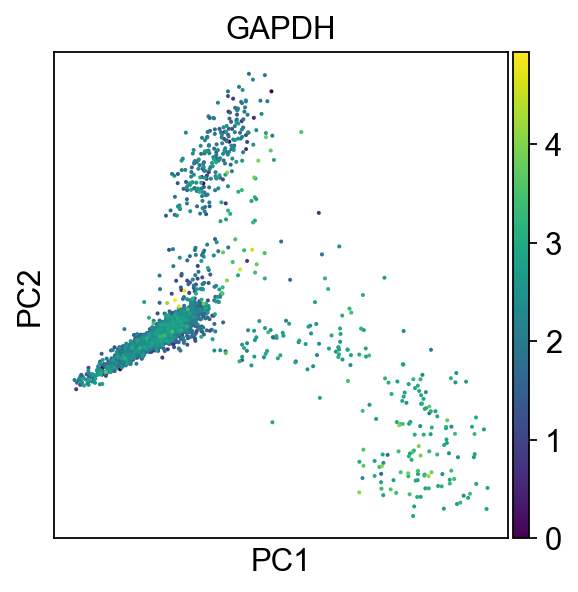

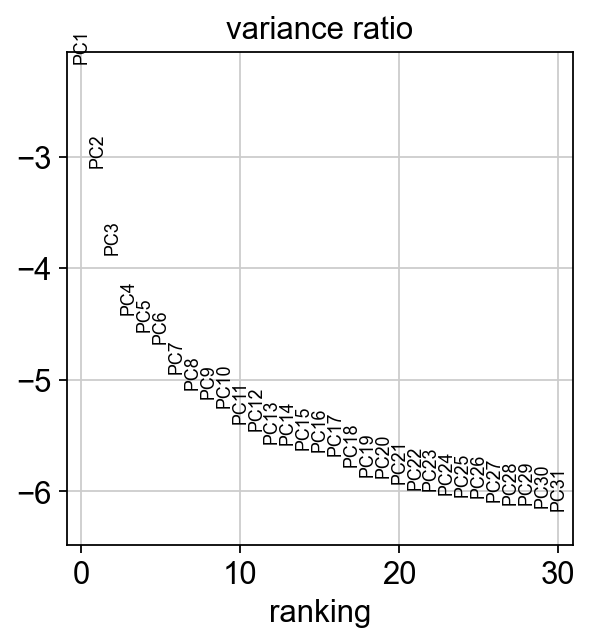

In [39]:
# PCA
sc.tl.pca(
    cca_l_filt_hv, 
    svd_solver='arpack'
)
sc.pl.pca(
    cca_l_filt_hv, 
    color='GAPDH'
)
sc.pl.pca_variance_ratio(
    cca_l_filt_hv, 
    log=True
)


In [40]:
cca_l_filt_hv.uns['hvg']

{'flavor': 'seurat'}

In [41]:
cca_l_filt_hv.uns[
    'pca'
]

{'params': {'zero_center': True, 'use_highly_variable': True},
 'variance': array([104.8241   ,  41.32498  ,  19.072596 ,  11.054708 ,   9.520224 ,
          8.589329 ,   6.528153 ,   5.680303 ,   5.2491746,   4.818031 ,
          4.1675706,   3.9233553,   3.4997764,   3.459308 ,   3.3206089,
          3.2641013,   3.1314077,   2.842482 ,   2.5910633,   2.572566 ,
          2.449428 ,   2.3136709,   2.2956831,   2.2086082,   2.1731653,
          2.1466112,   2.0877724,   2.032662 ,   2.0159764,   1.9661269,
          1.9225116,   1.9016837,   1.8767877,   1.8564392,   1.8497628,
          1.8076503,   1.7946515,   1.7914777,   1.7545862,   1.7372248,
          1.7209162,   1.7138207,   1.6950172,   1.6933434,   1.6796007,
          1.6671313,   1.6435776,   1.6331148,   1.6235605,   1.6184456],
       dtype=float32),
 'variance_ratio': array([0.11436016, 0.0450844 , 0.02080767, 0.01206038, 0.0103863 ,
        0.00937072, 0.00712203, 0.00619705, 0.0057267 , 0.00525634,
        0.0045467

The PCA analysis results are stored in the 'unstructured data' `uns` subaddress of the anndata object

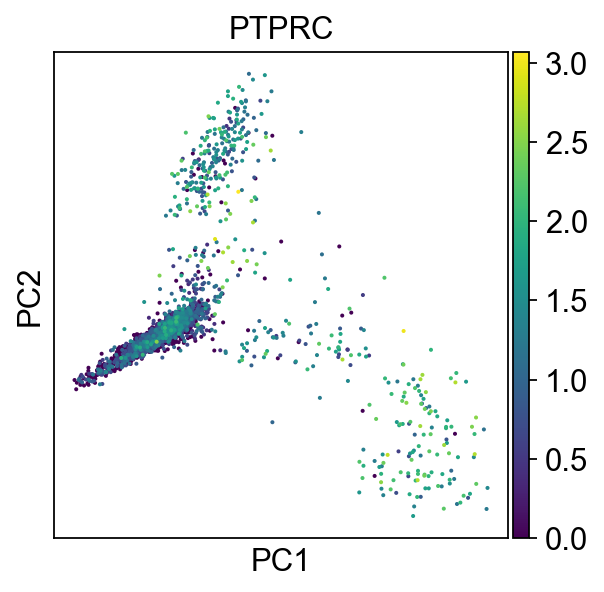

In [42]:
sc.pl.pca(
    cca_l_filt_hv, 
    color='PTPRC'
)

Another thing to note here: Even with the preselection that all of these cells were CD45+ by FACS, the transcript level is not super consistent. 

In [43]:
cca_l_filt_hv

AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_count', '10K', 'log1p'

In [44]:
# These are the actual ordination values, stored in the .obsm subaddress.
cca_l_filt_hv.obsm['X_pca'].shape

(9079, 50)

Using the PCA ordinations, we will now create a 'neighbor' graph to aid in future ordination and clustering.

In [45]:
# Ok, neighbor time
sc.pp.neighbors(
    cca_l_filt_hv, 
    n_neighbors=15, 
    n_pcs=30,
    method='umap',
    metric='euclidean',
    random_state=42,
)
cca_l_filt_hv



computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:06)


AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'raw_count', '10K', 'log1p'
    obsp: 'distances', 'connectivities'

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


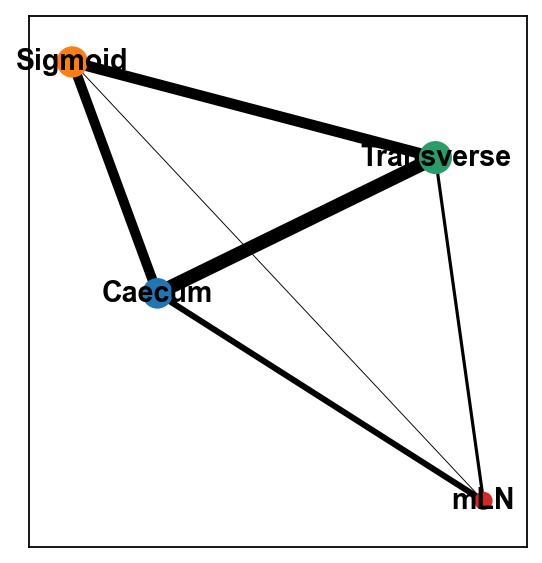

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)


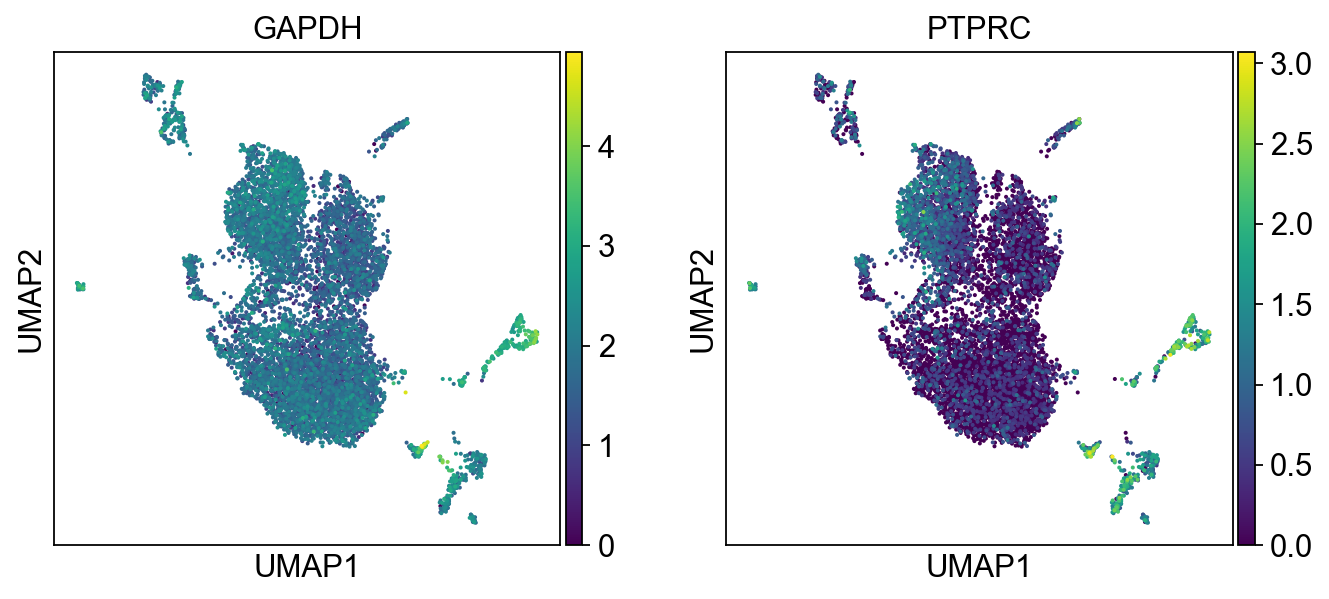

In [46]:
#  partition-based graph abstraction (PAGA)
sc.tl.paga(
    cca_l_filt_hv,
    groups='region'
)
sc.pl.paga(cca_l_filt_hv, plot=True) 
sc.tl.umap(cca_l_filt_hv, init_pos='paga')
sc.pl.umap(
    cca_l_filt_hv, 
    color=['GAPDH', 'PTPRC']
)

#### Clustering!

This is related to (and uses some of the same prior analyses) but distinct from the UMAP plot above. Here we are going to try to identify 'clusters' of cells using an approach called leiden. There is a key parameter here `resolution`. The higher this number is the more clusters we get, the lower the fewer. 

Picking the correct value for `resolution` is a bit of artistry--based both on trying to have the clusters look visually 'correct' with respect to the ordination plot and clsuters we can see visually as well as 'correct' biologically (i.e., if we expect a certain number of distinct cell types, we should hopefully have one cluster per cell type).

This is a rather subjective part of single cell analysis that can have profound effects on subsequent hypothesis testing analysis and should be done with care, and verified when interpreting the results from others.


running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:02)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


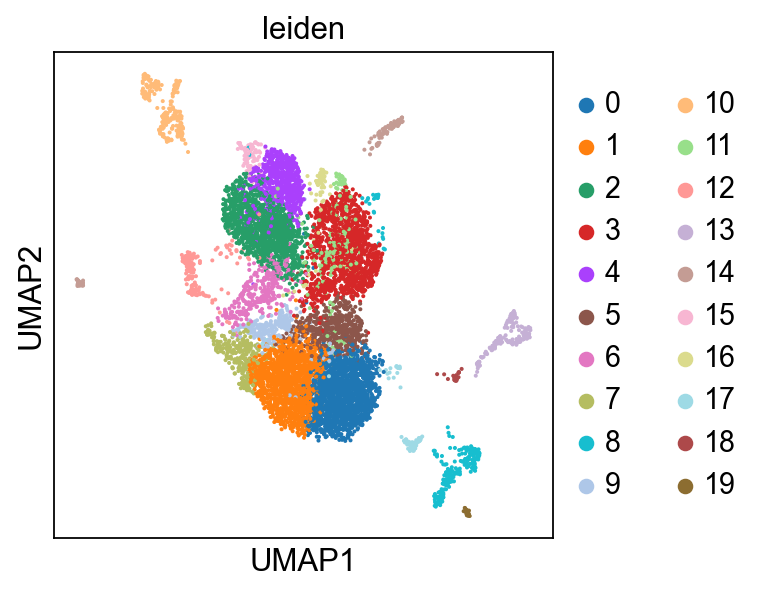

In [47]:
# Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=1,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
)

running Leiden clustering
    finished: found 11 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


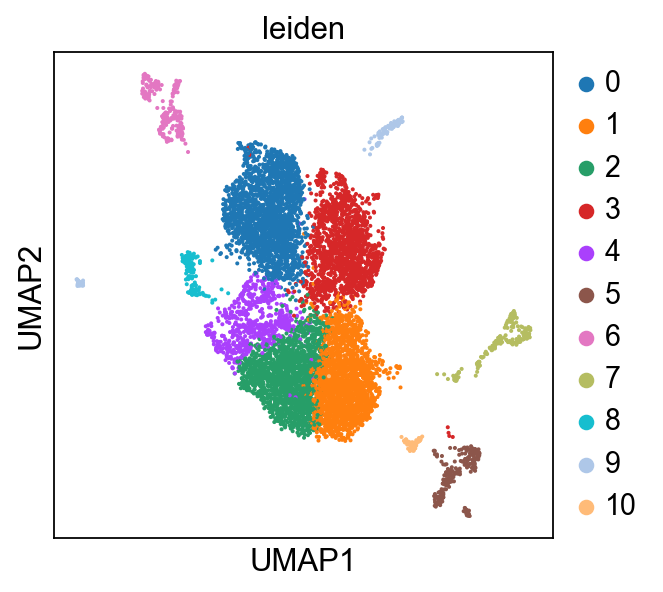

In [48]:
   # Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.5,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


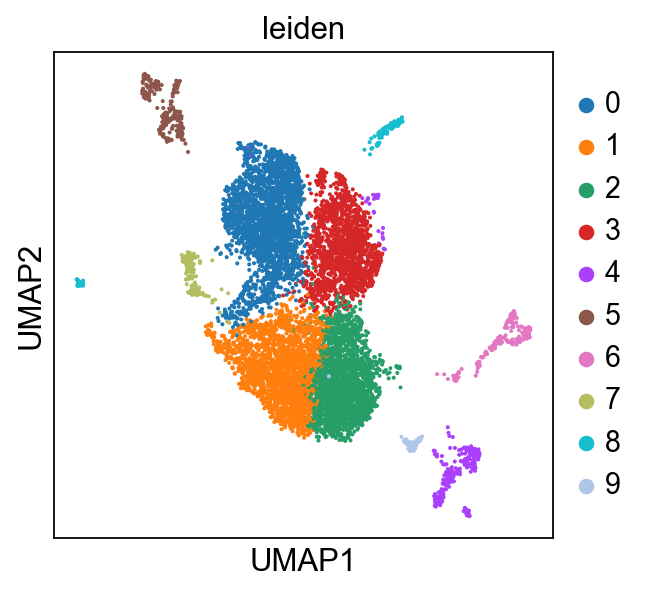

In [49]:
   # Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.4,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


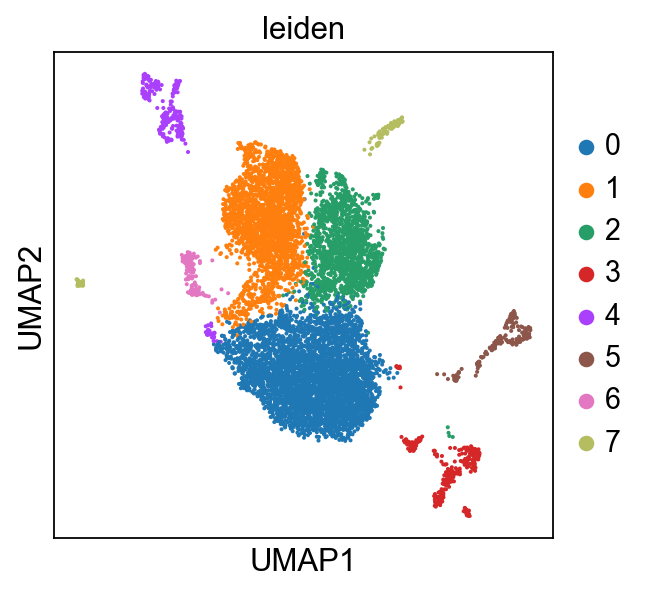

In [50]:
   # Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.3,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


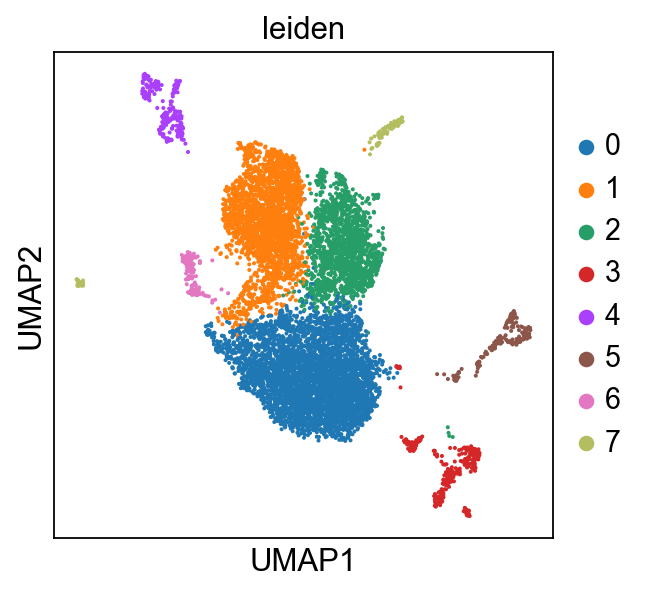

In [51]:
   # Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.2,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


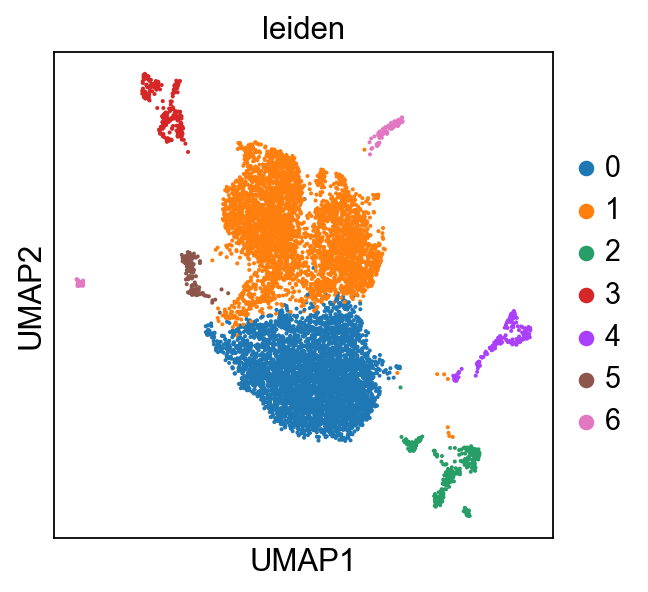

In [52]:
   # Clustering 
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.1,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

running Leiden clustering
    finished: found 7 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:01)


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


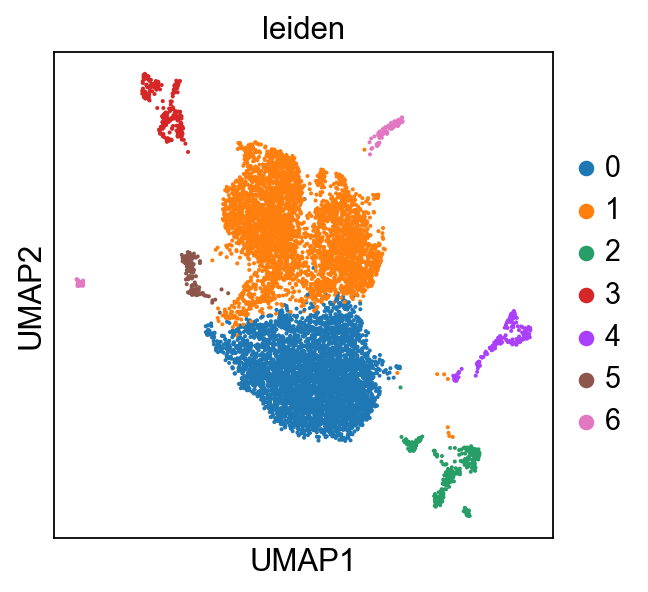

In [53]:
# Clustering -- Settle on a resolution of 0.1
sc.tl.leiden(
    cca_l_filt_hv,
    resolution=0.1,
    random_state=42,
    restrict_to=None,
    
)
sc.pl.umap(
    cca_l_filt_hv, 
    color=['leiden']
) 

In [54]:
cca_l_filt_hv

AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'paga', 'region_sizes', 'region_colors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count', '10K', 'log1p'
    obsp: 'distances', 'connectivities'

Notice we now have `leiden` in the `.uns` address as well as a column in the `obs` metadata. The latter is the cluster assigned to each cell.

Let's now go back to the genes and ask 'What are the genes most unique to this cluster'?

ranking genes
    finished: added to `.uns['rank_genes_groups__wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:06)


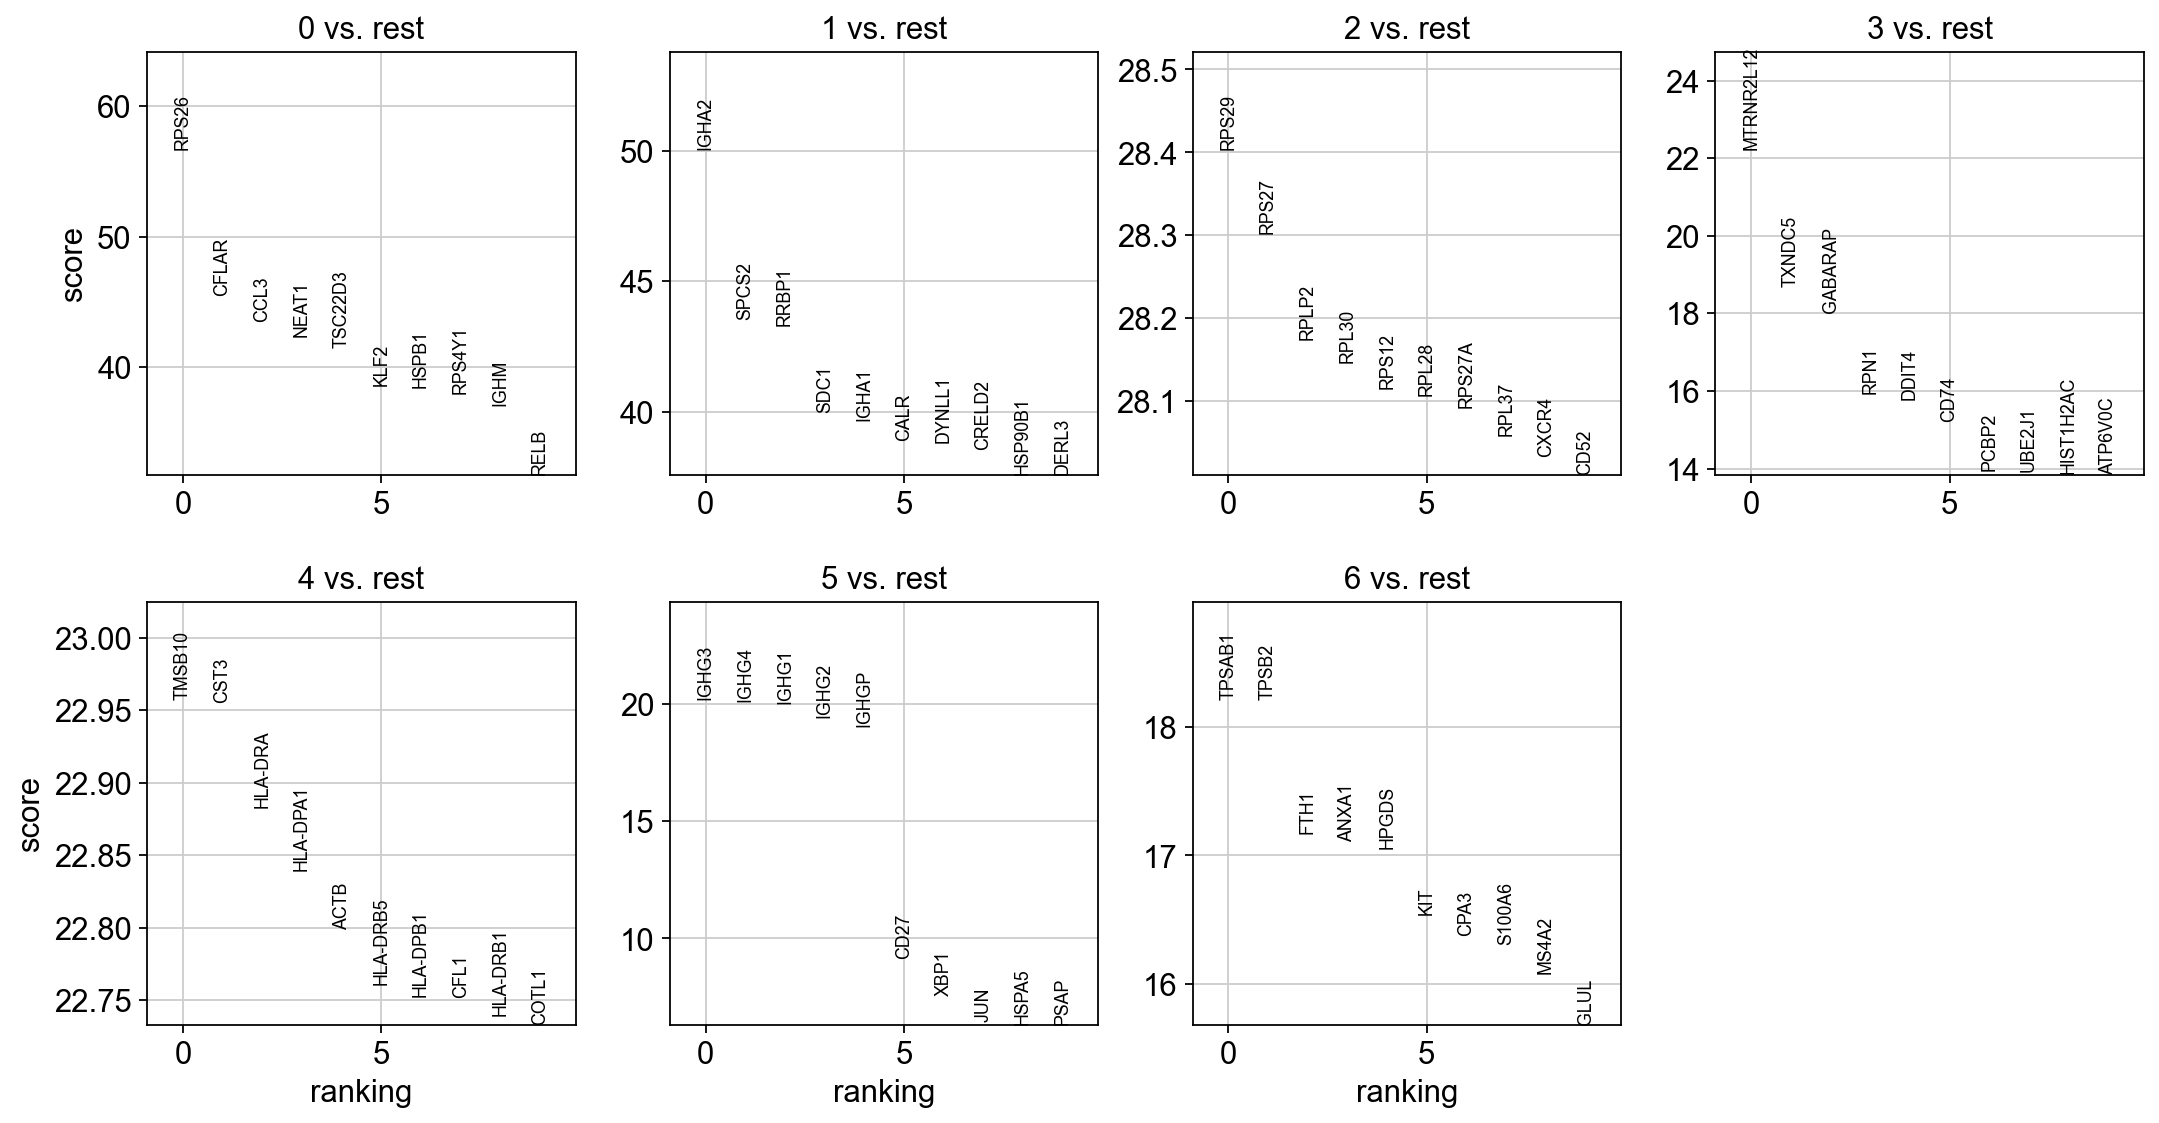

In [55]:
sc.tl.rank_genes_groups(
    cca_l_filt_hv,
    'leiden', 
    method='wilcoxon',
    key_added='rank_genes_groups__wilcoxon'
)
sc.pl.rank_genes_groups(
    cca_l_filt_hv, 
    n_genes=10, 
    sharey=False,
    key='rank_genes_groups__wilcoxon'
)



There is more than one approach. The rank sum (wilcoxon) is the most 'standard' for publication, but other approaches may be better in specific circumstances (such as logreg below)

ranking genes
    finished: added to `.uns['rank_genes_groups__logreg']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:13)


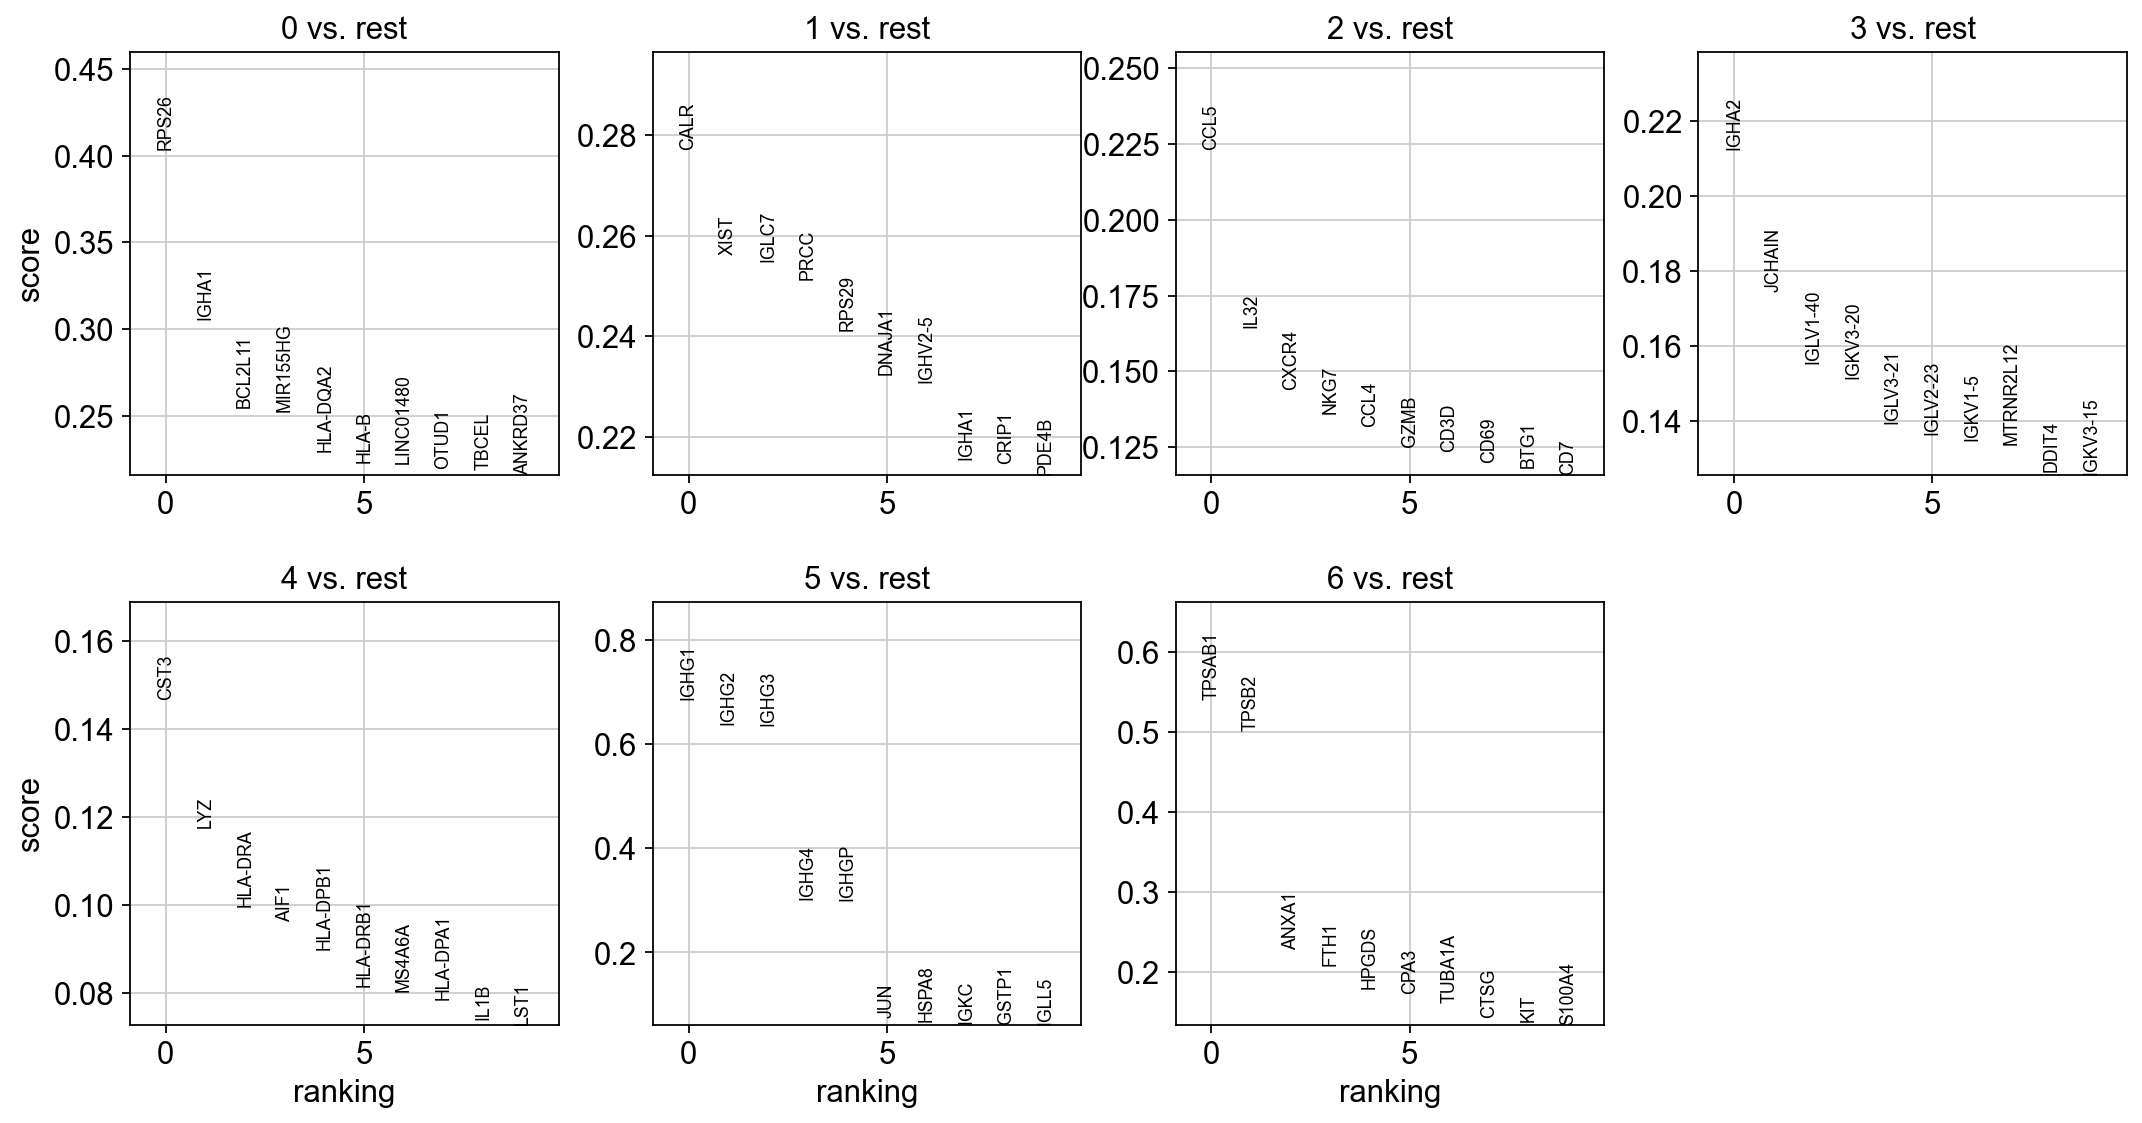

In [56]:
sc.tl.rank_genes_groups(
    cca_l_filt_hv,
    'leiden', 
    method='logreg',
    key_added='rank_genes_groups__logreg'
)
sc.pl.rank_genes_groups(
    cca_l_filt_hv, 
    n_genes=10, 
    sharey=False,
    key='rank_genes_groups__logreg'
)


In [57]:
cca_l_filt_hv

AnnData object with n_obs × n_vars = 9079 × 1056
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'paga', 'region_sizes', 'region_colors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups__wilcoxon', 'rank_genes_groups__logreg'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'raw_count', '10K', 'log1p'
    obsp: 'distances', 'connectivities'

The results are stored in the `.uns` address

In [58]:
cca_l_filt_hv.uns['rank_genes_groups__logreg'].keys()

dict_keys(['params', 'names', 'scores'])

I am going to use pandas to convert these into `long` format.

In [59]:
TOP_N = 10000
rgg_summary_LR = pd.merge(
    pd.DataFrame(
        cca_l_filt_hv.uns['rank_genes_groups__logreg']['names']
    ).head(TOP_N).melt(
        ignore_index=False,
        var_name='Cluster',
        value_name='names'
    ).reset_index().rename({'index': 'rank_order'}, axis=1),
    pd.DataFrame(
        cca_l_filt_hv.uns['rank_genes_groups__logreg']['scores']
    ).head(TOP_N).melt(
        ignore_index=False,
        var_name='Cluster',
        value_name='scores'
    ).reset_index().rename({'index': 'rank_order'}, axis=1),
    on=['Cluster', 'rank_order']
)

rgg_summary_LR[
    rgg_summary_LR.scores > 0.1
]


rank_order Cluster     names    scores
0               0       0     RPS26  0.403544
1               1       0     IGHA1  0.305624
2               2       0   BCL2L11  0.254938
3               3       0  MIR155HG  0.252761
4               4       0  HLA-DQA2  0.229644
...           ...     ...       ...       ...
60013          13       6      GLUL  0.117783
60014          14       6    IL1RL1  0.116165
60015          15       6       CD9  0.114010
60016          16       6       CLU  0.109993
60017          17       6      CD69  0.104466

[375 rows x 4 columns]

In [60]:
# I can store this myself in `.uns` for later.
cca_l_filt_hv.uns['rank_genes_groups__logreg__summary'] = rgg_summary_LR

In [61]:
cca_l_filt_hv.uns['rank_genes_groups__wilcoxon'].keys()

dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])

In [62]:
TOP_N = 10000
rgg_summary_wcx = pd.merge(
    pd.DataFrame(
        cca_l_filt_hv.uns['rank_genes_groups__wilcoxon']['names']
    ).head(TOP_N).melt(
        ignore_index=False,
        var_name='Cluster',
        value_name='names'
    ).reset_index().rename({'index': 'rank_order'}, axis=1),
    pd.DataFrame(
        cca_l_filt_hv.uns['rank_genes_groups__wilcoxon']['pvals_adj']
    ).head(TOP_N).melt(
        ignore_index=False,
        var_name='Cluster',
        value_name='pvals_adj'
    ).reset_index().rename({'index': 'rank_order'}, axis=1),
    on=['Cluster', 'rank_order']
)
rgg_summary_wcx = pd.merge(
    rgg_summary_wcx,
    pd.DataFrame(
        cca_l_filt_hv.uns['rank_genes_groups__wilcoxon']['scores']
    ).head(TOP_N).melt(
        ignore_index=False,
        var_name='Cluster',
        value_name='scores'
    ).reset_index().rename({'index': 'rank_order'}, axis=1),
    on=['Cluster', 'rank_order']
)
rgg_summary_wcx[
    rgg_summary_wcx.pvals_adj < 0.01
]

rank_order Cluster     names  pvals_adj     scores
0               0       0     RPS26   0.000000  56.681404
1               1       0     CFLAR   0.000000  45.474083
2               2       0      CCL3   0.000000  43.473640
3               3       0     NEAT1   0.000000  42.325249
4               4       0   TSC22D3   0.000000  41.515450
...           ...     ...       ...        ...        ...
61033        1033       6      PKIB   0.009400   3.425382
61034        1034       6     HDAC2   0.009617   3.418689
61035        1035       6    IQGAP1   0.009804   3.413175
61036        1036       6  TRAF3IP3   0.009888   3.410382
61037        1037       6     LACTB   0.009914   3.409402

[10880 rows x 5 columns]

In [63]:
cca_l_filt_hv.uns['rank_genes_groups__wilcoxon__summary'] = rgg_summary_wcx

Moving forward, we will now focus on the more standard wilcoxon approach, and filted down to the 'significant' (padj < 0.01) DEG for each cluster....

In [64]:
cluster_DEG = {}
for cluster in rgg_summary_wcx.Cluster.unique():
    cluster_DEG[cluster] = sorted(set(rgg_summary_wcx[
        (rgg_summary_wcx.Cluster == cluster) &
        (rgg_summary_wcx.pvals_adj < 0.01)
    ].names))
    

In [65]:
cca_l_filt_hv.uns['leiden_DEG'] = cluster_DEG

#### GSEA for cluster identification

We will now use the `gseapy` library plus these DEG (or differentially expressed genes) to try to find out the cell type for each cluster. 
This again is a point of lots of art in single-cell analysis--with people often relying upon their knowledge and eyeballing the DEG lists to come up with a 'name' for each cluster.

Given it is subjective, this is another step where some very careful and thoughtful evaluation of an analysis is key. 

In [66]:
[
    n for n in gp.get_library_name()
    if 'cell' in n.lower()
]

['ARCHS4_Cell-lines',
 'Azimuth_Cell_Types_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'GO_Cellular_Component_2013',
 'GO_Cellular_Component_2015',
 'GO_Cellular_Component_2017',
 'GO_Cellular_Component_2017b',
 'GO_Cellular_Component_2018',
 'GO_Cellular_Component_2021',
 'GO_Cellular_Component_2023',
 'NCI-60_Cancer_Cell_Lines',
 'SubCell_BarCode']

In [67]:
cluster_GSEA = {}
for cl, deg in cluster_DEG.items():
    print(
        cl,
        len(deg)
    )
    cluster_GSEA[cl] = gp.enrichr(
        gene_list=list(deg),
        gene_sets=['Azimuth_Cell_Types_2021']
    )

0 536
1 1969
2 3205
3 270
4 3806
5 56
6 1038


In [68]:
combined_deg = set()
for cl, cl_gsea in cluster_GSEA.items():
    print(f"Cluster {cl}")
    display(
        cl_gsea.results[
            cl_gsea.results['Adjusted P-value'] < 0.05
        ]
    )
    combined_deg.update({
        g
        for gl in 
        cl_gsea.results[
            cl_gsea.results['Adjusted P-value'] < 0.05
        ].head(1).Genes
        for g in gl.split(';')
    })

cca_l_filt.uns['combined_deg'] = sorted(combined_deg)

Cluster 0


Gene_set                                               Term  \
0  Azimuth_Cell_Types_2021                          Basophil/Mast 2 CL0000766   
1  Azimuth_Cell_Types_2021   Intermediate B Cell, Kappa Light Chain CL0000785   
2  Azimuth_Cell_Types_2021  Intermediate B Cell, Lambda Light Chain CL0000785   
3  Azimuth_Cell_Types_2021                      Intermediate B Cell CL0000785   
4  Azimuth_Cell_Types_2021                             Naive B Cell CL0000788   
5  Azimuth_Cell_Types_2021                         Natural Killer T CL0000814   

  Overlap   P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    5/10  0.000003          0.000223            0                     0   
1    3/10  0.001996          0.029135            0                     0   
2    3/10  0.001996          0.029135            0                     0   
3    3/10  0.001996          0.029135            0                     0   
4    3/10  0.001996          0.029135            0                     0   
5    3/11  0.002690          0.032723            0                     0   

   Odds Ratio  Combined Score                       Genes  
0   36.645951      465.307691  SRGN;CD69;AREG;BIRC3;ICAM1  
1   15.644867       97.261403       IGHM;MARCKS;TNFRSF13B  
2   15.644867       97.261403        IGHM;TNFRSF13B;IGLC2  
3   15.644867       97.261403         IGHM;AIM2;TNFRSF13B  
4   15.644867       97.261403              IGHM;BTG1;YBX3  
5   13.688555       81.013956        DUSP4;LGALS1;ZFP36L2

Cluster 1


Gene_set                   Term Overlap       P-value  \
0  Azimuth_Cell_Types_2021       Plasma CL0000786   10/10  8.376866e-11   
1  Azimuth_Cell_Types_2021  Plasma Cell CL0000786    8/10  3.266809e-07   
2  Azimuth_Cell_Types_2021  Plasmablast CL0000980    8/18  1.538969e-04   

   Adjusted P-value  Old P-value  Old Adjusted P-value     Odds Ratio  \
0      1.021978e-08            0                     0  180310.000000   
1      1.992754e-05            0                     0      36.775115   
2      6.258476e-03            0                     0       7.351759   

   Combined Score                                              Genes  
0    4.183726e+06  XBP1;PRDX4;SSR4;DERL3;POU2AF1;MZB1;TNFRSF17;HS...  
1    5.492099e+02  CD79A;DERL3;POU2AF1;MZB1;TNFRSF17;TXNDC11;IGHA...  
2    6.454277e+01  CPNE5;DERL3;NT5DC2;POU2AF1;MZB1;TNFRSF17;IGHA2...

Cluster 2


Gene_set  \
0   Azimuth_Cell_Types_2021   
1   Azimuth_Cell_Types_2021   
2   Azimuth_Cell_Types_2021   
3   Azimuth_Cell_Types_2021   
4   Azimuth_Cell_Types_2021   
5   Azimuth_Cell_Types_2021   
6   Azimuth_Cell_Types_2021   
7   Azimuth_Cell_Types_2021   
8   Azimuth_Cell_Types_2021   
9   Azimuth_Cell_Types_2021   
10  Azimuth_Cell_Types_2021   
11  Azimuth_Cell_Types_2021   
12  Azimuth_Cell_Types_2021   
13  Azimuth_Cell_Types_2021   
14  Azimuth_Cell_Types_2021   
15  Azimuth_Cell_Types_2021   
16  Azimuth_Cell_Types_2021   
17  Azimuth_Cell_Types_2021   
18  Azimuth_Cell_Types_2021   
19  Azimuth_Cell_Types_2021   
20  Azimuth_Cell_Types_2021   
21  Azimuth_Cell_Types_2021   
22  Azimuth_Cell_Types_2021   
23  Azimuth_Cell_Types_2021   
24  Azimuth_Cell_Types_2021   
25  Azimuth_Cell_Types_2021   
26  Azimuth_Cell_Types_2021   
27  Azimuth_Cell_Types_2021   
28  Azimuth_Cell_Types_2021   
29  Azimuth_Cell_Types_2021   
30  Azimuth_Cell_Types_2021   
31  Azimuth_Cell_Types_2021   
32  Azimuth_Cell_Types_2021   
33  Azimuth_Cell_Types_2021   
34  Azimuth_Cell_Types_2021   
35  Azimuth_Cell_Types_2021   
36  Azimuth_Cell_Types_2021   
37  Azimuth_Cell_Types_2021   
38  Azimuth_Cell_Types_2021   
39  Azimuth_Cell_Types_2021   
40  Azimuth_Cell_Types_2021   
41  Azimuth_Cell_Types_2021   
42  Azimuth_Cell_Types_2021   
43  Azimuth_Cell_Types_2021   
44  Azimuth_Cell_Types_2021   

                                                 Term Overlap       P-value  \
0                                    B Cell CL0000785   10/10  1.103531e-08   
1                                         B CL0000236   10/10  1.103531e-08   
2                              Naive B Cell CL0000788   10/10  1.103531e-08   
3                       Intermediate B Cell CL0000785    9/10  5.909772e-07   
4                    CD4+ Memory/Effector T CL0000624    8/10  1.430059e-05   
5                    CD8+ Memory/Effector T CL0000625    8/10  1.430059e-05   
6                            Dendritic Cell CL0000451    8/10  1.430059e-05   
7    Intermediate B Cell, Kappa Light Chain CL0000785    8/10  1.430059e-05   
8   Intermediate B Cell, Lambda Light Chain CL0000785    8/10  1.430059e-05   
9                             Memory B Cell CL0000787    8/10  1.430059e-05   
10         Naive B Cell, Lambda Light Chain CL0000788    8/10  1.430059e-05   
11                           CD16+ Monocyte CL0002396   11/20  7.176702e-05   
12         Memory B Cell, Kappa Light Chain CL0000787     7/9  7.189403e-05   
13          Naive B Cell, Kappa Light Chain CL0000788     7/9  7.189403e-05   
14                  CD4+ Central Memory T 3 CL0000897    7/10  2.062800e-04   
15                 CD4+ Effector Memory T 3 CL0001044    7/10  2.062800e-04   
16                              CD4+ T Cell CL0000624    7/10  2.062800e-04   
17                  CD8+ Central Memory T 3 CL0000909    7/10  2.062800e-04   
18          Conventional Dendritic Cell 2 2 CL0002399    7/10  2.062800e-04   
19                 Myeloid Dendritic Type 2 CL0000782    7/10  2.062800e-04   
20                             CD8+ Naive T CL0000900   11/24  5.713579e-04   
21                             CD4+ Naive T CL0000895    9/19  1.367003e-03   
22                         CD4+ Cytotoxic T CL0000934    7/13  1.886262e-03   
23                    CD4+ Central Memory T CL0000897    6/10  1.969829e-03   
24                   CD4+ Effector Memory T CL0001044    6/10  1.969829e-03   
25                 CD4+ Effector Memory T 1 CL0001044    6/10  1.969829e-03   
26                 CD8+ Effector Memory T 1 CL0001050     5/8  3.849639e-03   
27              Plasmacytoid Dendritic Cell CL0000784    7/15  5.262452e-03   
28                          Basophil/Mast 2 CL0000766    5/10  1.307435e-02   
29                  CD4+ Central Memory T 1 CL0000897    5/10  1.307435e-02   
30        TYROBP+ CD74+ Layer 1-6 Microglia CL0000129    5/10  1.307435e-02   
31                                    CD8 T CL0000625    5/10  1

Cluster 3


Gene_set                                         Term  \
0   Azimuth_Cell_Types_2021                             Plasma CL0000786   
1   Azimuth_Cell_Types_2021                             B Cell CL0000785   
2   Azimuth_Cell_Types_2021                        Plasma Cell CL0000786   
3   Azimuth_Cell_Types_2021             Plasmacytoid Dendritic CL0000784   
4   Azimuth_Cell_Types_2021                        Plasmablast CL0000980   
5   Azimuth_Cell_Types_2021   Memory B Cell, Kappa Light Chain CL0000787   
6   Azimuth_Cell_Types_2021                 Activated Stellate CL0002410   
7   Azimuth_Cell_Types_2021                Intermediate B Cell CL0000785   
8   Azimuth_Cell_Types_2021                      Memory B Cell CL0000787   
9   Azimuth_Cell_Types_2021  TYROBP+ CD74+ Layer 1-6 Microglia CL0000129   
10  Azimuth_Cell_Types_2021    Conventional Dendritic Cell 2 2 CL0002399   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0     5/10  1.030279e-07          0.000005            0                     0   
1     3/10  2.721792e-04          0.004446            0                     0   
2     3/10  2.721792e-04          0.004446            0                     0   
3     3/11  3.705164e-04          0.004539            0                     0   
4     3/18  1.708594e-03          0.016744            0                     0   
5      2/9  6.140189e-03          0.033887            0                     0   
6     2/10  7.607197e-03          0.033887            0                     0   
7     2/10  7.607197e-03          0.033887            0                     0   
8     2/10  7.607197e-03          0.033887            0                     0   
9     2/10  7.607197e-03          0.033887            0                     0   
10    2/10  7.607197e-03          0.033887            0                     0   

    Odds Ratio  Combined Score                            Genes  
0    74.433962     1197.513402  PRDX4;SSR4;DERL3;HSP90B1;SEC11C  
1    31.658106      259.882968               CD74;CD79A;RALGPS2  
2    31.658106      259.882968               CD79A;DERL3;TXNDC5  
3    27.699438      218.842540                 IRF4;NPC2;SEC61B  
4    14.767790       94.101609               DERL3;IGHA2;TXNDC5  
5    21.026652      107.086633                    CD79A;RALGPS2  
6    18.397388       89.754610                     COL6A3;TIMP1  
7    18.397388       89.754610                    CD79A;RALGPS2  
8    18.397388       89.754610                    CD79A;RALGPS2  
9    18.397388       89.754610                       CD74;PTPRC  
10   18.397388       89.754610                       CD74;BASP1

Cluster 4


Gene_set                                           Term  \
0   Azimuth_Cell_Types_2021                       CD16+ Monocyte CL0002396   
1   Azimuth_Cell_Types_2021                       CD14+ Monocyte CL0002057   
2   Azimuth_Cell_Types_2021                       Dendritic Cell CL0000451   
3   Azimuth_Cell_Types_2021                      EREG+ Dendritic CL0000451   
4   Azimuth_Cell_Types_2021                Intermediate Monocyte CL0002393   
5   Azimuth_Cell_Types_2021                             Monocyte CL0000576   
6   Azimuth_Cell_Types_2021        Conventional Dendritic Cell 2 CL0002399   
7   Azimuth_Cell_Types_2021      Conventional Dendritic Cell 2 1 CL0002399   
8   Azimuth_Cell_Types_2021      Conventional Dendritic Cell 2 2 CL0002399   
9   Azimuth_Cell_Types_2021                            Dendritic CL0000451   
10  Azimuth_Cell_Types_2021                               Immune CL0000738   
11  Azimuth_Cell_Types_2021             Myeloid Dendritic Type 2 CL0000782   
12  Azimuth_Cell_Types_2021                Nonclassical Monocyte CL0000875   
13  Azimuth_Cell_Types_2021             OLR1+ Classical Monocyte CL0000860   
14  Azimuth_Cell_Types_2021        Conventional Dendritic Cell 1 CL0002394   
15  Azimuth_Cell_Types_2021                   Classical Monocyte CL0000860   
16  Azimuth_Cell_Types_2021                    IGSF21+ Dendritic CL0000451   
17  Azimuth_Cell_Types_2021    TYROBP+ CD74+ Layer 1-6 Microglia CL0000129   
18  Azimuth_Cell_Types_2021                           Macrophage CL0000235   
19  Azimuth_Cell_Types_2021  Microglia / Perivascular Macrophage CL0000881   
20  Azimuth_Cell_Types_2021               Capillary Intermediate CL0002144   
21  Azimuth_Cell_Types_2021             Myeloid Dendritic Type 1 CL0000782   

   Overlap       P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0    18/20  1.325777e-11      2.797389e-09            0                     0   
1    15/16  1.999125e-10      2.109077e-08            0                     0   
2    10/10  6.168350e-08      2.169203e-06            0                     0   
3    10/10  6.168350e-08      2.169203e-06            0                     0   
4    10/10  6.168350e-08      2.169203e-06            0                     0   
5    10/10  6.168350e-08      2.169203e-06            0                     0   
6     9/10  2.692590e-06      4.058118e-05            0                     0   
7     9/10  2.692590e-06      4.058118e-05            0                     0   
8     9/10  2.692590e-06      4.058118e-05            0                     0   
9     9/10  2.692590e-06      4.058118e-05            0                     0   
10    9/10  2.692590e-06      4.058118e-05            0                     0   
11    9/10  2.692590e-06      4.058118e-05            0                     0   
12    9/10  2.692590e-06      4.058118e-05            0                     0   
13    9/10  2.692590e-06      4.058118e-05            0                     0   
14   10/13  1.000287e-05      1.407071e-04            0                     0   
15    8/10  5.317083e-05      6.232803e-04            0                     0   
16    8/10  5.317083e-05      6.232803e-04            0                     0   
17    8/10  5.317083e-05      6.232803e-04            0                     0   
18    8/12  4.050817e-04      4.498538e-03            0                     0   
19    7/10  6.269079e-04      6.613878e-03            0                     0   
20    6/10  4.904963e-03      4.704305e-02            0                     0   
21    6/10  4.904963e-03      4.704305e-02            0                     0   

       Odds Ratio  Combined Score  \
0       38.470961    9.635605e+02   
1       64.071485    1.430918e+03   
2   161940.000000    2.688406e+06   
3   161940.000000    2.688406e+06   
4   161940.000000    2.688406e+06   
5   161940.000000    2.688406e+06   
6       38.382144    4.922513e+02   
7       38.382144    4.922513e+02   
8       38.382144    4.9225

Cluster 5


Gene_set  \
0   Azimuth_Cell_Types_2021   
1   Azimuth_Cell_Types_2021   
2   Azimuth_Cell_Types_2021   
3   Azimuth_Cell_Types_2021   
4   Azimuth_Cell_Types_2021   
5   Azimuth_Cell_Types_2021   
6   Azimuth_Cell_Types_2021   
7   Azimuth_Cell_Types_2021   
8   Azimuth_Cell_Types_2021   
9   Azimuth_Cell_Types_2021   
10  Azimuth_Cell_Types_2021   
11  Azimuth_Cell_Types_2021   
12  Azimuth_Cell_Types_2021   
13  Azimuth_Cell_Types_2021   
14  Azimuth_Cell_Types_2021   
15  Azimuth_Cell_Types_2021   
16  Azimuth_Cell_Types_2021   
17  Azimuth_Cell_Types_2021   
18  Azimuth_Cell_Types_2021   
19  Azimuth_Cell_Types_2021   
20  Azimuth_Cell_Types_2021   
21  Azimuth_Cell_Types_2021   
22  Azimuth_Cell_Types_2021   
23  Azimuth_Cell_Types_2021   
24  Azimuth_Cell_Types_2021   
25  Azimuth_Cell_Types_2021   
26  Azimuth_Cell_Types_2021   
27  Azimuth_Cell_Types_2021   
28  Azimuth_Cell_Types_2021   
29  Azimuth_Cell_Types_2021   
30  Azimuth_Cell_Types_2021   
31  Azimuth_Cell_Types_2021   
32  Azimuth_Cell_Types_2021   
33  Azimuth_Cell_Types_2021   
34  Azimuth_Cell_Types_2021   
35  Azimuth_Cell_Types_2021   
36  Azimuth_Cell_Types_2021   
37  Azimuth_Cell_Types_2021   

                                                 Term Overlap       P-value  \
0                                    Plasma CL0000786    5/10  3.572326e-11   
1           Naive B Cell, Kappa Light Chain CL0000788     3/9  1.725753e-06   
2                                    B Cell CL0000785    3/10  2.460474e-06   
3                                         B CL0000236    3/10  2.460474e-06   
4                               Plasma Cell CL0000786    3/10  2.460474e-06   
5          Memory B Cell, Kappa Light Chain CL0000787     2/9  2.737325e-04   
6                       Intermediate B Cell CL0000785    2/10  3.415510e-04   
7                       Double-negative T 2 CL0000935    2/10  3.415510e-04   
8                                  Monocyte CL0000576    2/10  3.415510e-04   
9          Naive B Cell, Lambda Light Chain CL0000788    2/10  3.415510e-04   
10                             Naive B Cell CL0000788    2/10  3.415510e-04   
11              Plasmacytoid Dendritic Cell CL0000784    2/15  7.898230e-04   
12                              Plasmablast CL0000980    2/18  1.144700e-03   
13  FEZF2+ FILIP1L+ Layer 5-6 Glutamatergic Neuron...     1/8  2.218539e-02   
14   Intermediate B Cell, Kappa Light Chain CL0000785    1/10  2.765579e-02   
15  Intermediate B Cell, Lambda Light Chain CL0000785    1/10  2.765579e-02   
16                        Non-neuronal Cell CL0000548    1/10  2.765579e-02   
17                    Nonclassical Monocyte CL0000875    1/10  2.765579e-02   
18          Conventional Dendritic Cell 2 1 CL0002399    1/10  2.765579e-02   
19                                Dendritic CL0000451    1/10  2.765579e-02   
20                    Differentiating Basal CL0000646    1/10  2.765579e-02   
21    LAMP5+ NMBR+ Layer 1 GABAergic Neuron CL0000617    1/10  2.765579e-02   
22                      Double-negative T 1 CL0000935    1/10  2.765579e-02   
23                              Endothelial CL0000115    1/10  2.765579e-02   
24                          EREG+ Dendritic CL0000451    1/10  2.765579e-02   
25                 Capillary Intermediate 2 CL0002144    1/10  2.765579e-02   
26                   Capillary Intermediate CL0002144    1/10  2.765579e-02   
27                  CD4+ Central Memory T 2 CL0000897    1/10  2.765579e-02   
28   SST+ PRRT4+ Layer 1-2 GABAergic Neuron CL0000617    1/10  2.765579e-02   
29                 CD4+ Effector Memory T 1 CL0001044    1/10  2.765579e-02   
30  PVALB+ ISG20+ Layer 3-5 GABAergic Neuron CL000...    1/10  2.765579e-02   
31                            Memory B Cell CL0000787    1/10  2.765579e-02   
32                      Memory Regulatory T CL0000815    1/10  2.765579e-02   
33                CD56-dim Natural Killer 2 CL0000939    1/10  2.765579e-02   
34                         GABAergic Neuron 

Cluster 6


Gene_set                               Term Overlap  \
0  Azimuth_Cell_Types_2021            Basophil/Mast CL0000766   10/10   
1  Azimuth_Cell_Types_2021          Basophil/Mast 1 CL0000766    8/10   
2  Azimuth_Cell_Types_2021          Basophil/Mast 2 CL0000766    7/10   
3  Azimuth_Cell_Types_2021           CD16+ Monocyte CL0002396    8/20   
4  Azimuth_Cell_Types_2021                   Immune CL0000738    5/10   
5  Azimuth_Cell_Types_2021     Innate Lymphoid Cell CL0001065    5/14   
6  Azimuth_Cell_Types_2021             CD8+ Naive T CL0000900    6/24   
7  Azimuth_Cell_Types_2021  CD4+ Central Memory T 2 CL0000897    4/10   
8  Azimuth_Cell_Types_2021         TREM2+ Dendritic CL0000451    4/10   

        P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0  1.360140e-13      1.999406e-11            0                     0   
1  2.101971e-09      1.544949e-07            0                     0   
2  1.039530e-07      5.093697e-06            0                     0   
3  3.689067e-06      1.355732e-04            0                     0   
4  7.549720e-05      2.219618e-03            0                     0   
5  5.037347e-04      1.234150e-02            0                     0   
6  1.156918e-03      1.923009e-02            0                     0   
7  1.177352e-03      1.923009e-02            0                     0   
8  1.177352e-03      1.923009e-02            0                     0   

      Odds Ratio  Combined Score  \
0  189620.000000    5.617686e+06   
1      73.631068    1.471177e+03   
2      42.907533    6.899243e+02   
3      12.265372    1.534415e+02   
4      18.351404    1.741808e+02   
5      10.193073    7.740070e+01   
6       6.118863    4.137573e+01   
7      12.221792    8.242972e+01   
8      12.221792    8.242972e+01   

                                               Genes  
0  CPA3;HPGDS;GRAP2;HDC;KIT;VWA5A;GATA2;MS4A2;TPS...  
1   CPA3;HPGDS;GNPTAB;RGS13;KIT;MS4A2;TPSAB1;SLC18A2  
2            KDM6B;SRGN;GPR65;CD69;GATA2;TPSAB1;AREG  
3   FCER1G;IFITM2;PTPRC;RPS19;COTL1;NAP1L1;YBX1;SAT1  
4                     SRGN;FCER1G;TYROBP;LAPTM5;APOE  
5                       HPGDS;FCER1G;TYROBP;KIT;SOX4  
6                    ITGB1;LDHB;LGALS1;ID2;RGS10;VIM  
7                    MIR4435-2HG;TMSB4X;ITM2A;TMSB10  
8                               CSTB;APOC1;CAPG;APOE

In [69]:
combined_deg

{'AIF1',
 'AREG',
 'BANK1',
 'BIRC3',
 'CD44',
 'CD69',
 'CD74',
 'CD79A',
 'CD79B',
 'COTL1',
 'CPA3',
 'DERL3',
 'FCER1G',
 'FCGR3A',
 'FCN1',
 'GATA2',
 'GRAP2',
 'HDC',
 'HES4',
 'HLA-DQA1',
 'HPGDS',
 'HSP90B1',
 'ICAM1',
 'IER5',
 'IFITM2',
 'IFITM3',
 'IGHM',
 'KIT',
 'LILRB2',
 'LST1',
 'MANF',
 'MEF2C',
 'MS4A1',
 'MS4A2',
 'MS4A7',
 'MZB1',
 'NAP1L1',
 'POU2AF1',
 'PRDX4',
 'PTPRC',
 'RALGPS2',
 'RHOC',
 'RPS19',
 'SAT1',
 'SEC11C',
 'SRGN',
 'SSR4',
 'TNFRSF13C',
 'TNFRSF17',
 'TPSAB1',
 'VWA5A',
 'XBP1',
 'YBX1'}

#### Assigning cell types to each cluster..

This again is quite subjective and based upon my interpretation of the per cluster GSEA output. Do you agree?

/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


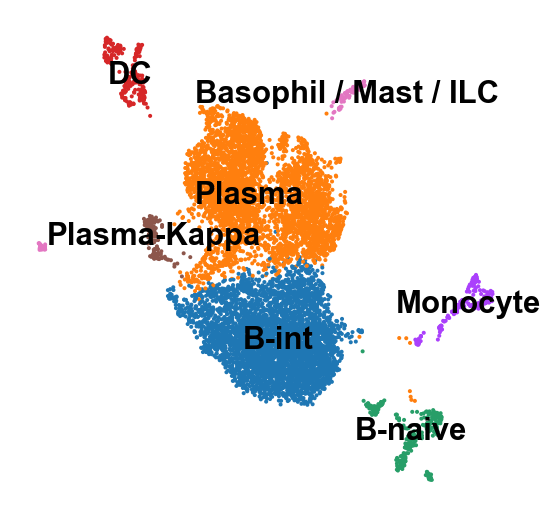

In [70]:
new_cluster_names = [
    'B-int',  # 0
    'Plasma', # 1
    'B-naive', #2
    'DC', #3
    'Monocyte', #4
    'Plasma-Kappa', # 5
    'Basophil / Mast / ILC', #6
]
cca_l_filt_hv.rename_categories(
    'leiden', new_cluster_names
)
sc.pl.umap(cca_l_filt_hv,
           color='leiden', 
           legend_loc='on data', 
           title='', 
           frameon=False,
)


### Combining and saving results..

Let's build our 'final' representation of lymphocytes in the colonic tissues.
Instead of just the transformed data, and only the highly variable genes, let's go back to after the more conservative filtering steps.
Thankfully those are stored in `.raw` and we can collect them again!

In [71]:
cca_l_final = cca_l_filt_hv.raw.to_adata().copy()
cca_l_final.layers = cca_l_filt.layers

cca_l_final

AnnData object with n_obs × n_vars = 9079 × 16903
    obs: 'Fraction', 'batch', 'donor', 'gender', 'region', 'n_counts', 'percent_mito', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_MT', 'pct_counts_MT', 'leiden'
    var: 'MT', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'paga', 'region_sizes', 'region_colors', 'umap', 'leiden', 'leiden_colors', 'rank_genes_groups__wilcoxon', 'rank_genes_groups__logreg', 'rank_genes_groups__logreg__summary', 'rank_genes_groups__wilcoxon__summary', 'leiden_DEG'
    obsm: 'X_pca', 'X_umap'
    layers: 'raw_count', '10K'
    obsp: 'distances', 'connectivities'

Our cell types are still here!

/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


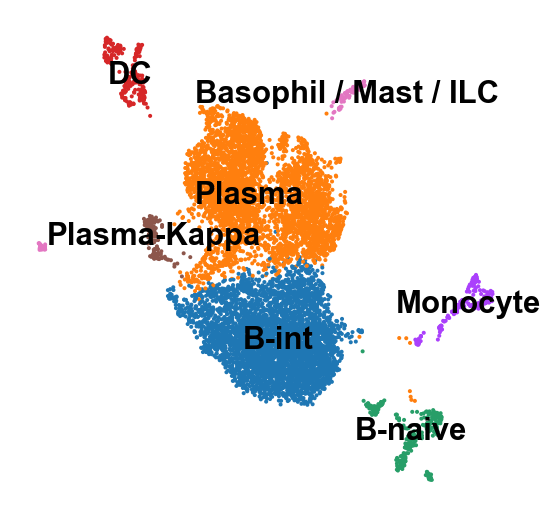

In [72]:
sc.pl.umap(
    cca_l_final,    
    color='leiden', 
    legend_loc='on data', 
    title='', 
    frameon=False,
)


A few more sanity checks to look at the per-cluster expression levels of given 'DEGs' most critical for our cell type identification.


/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


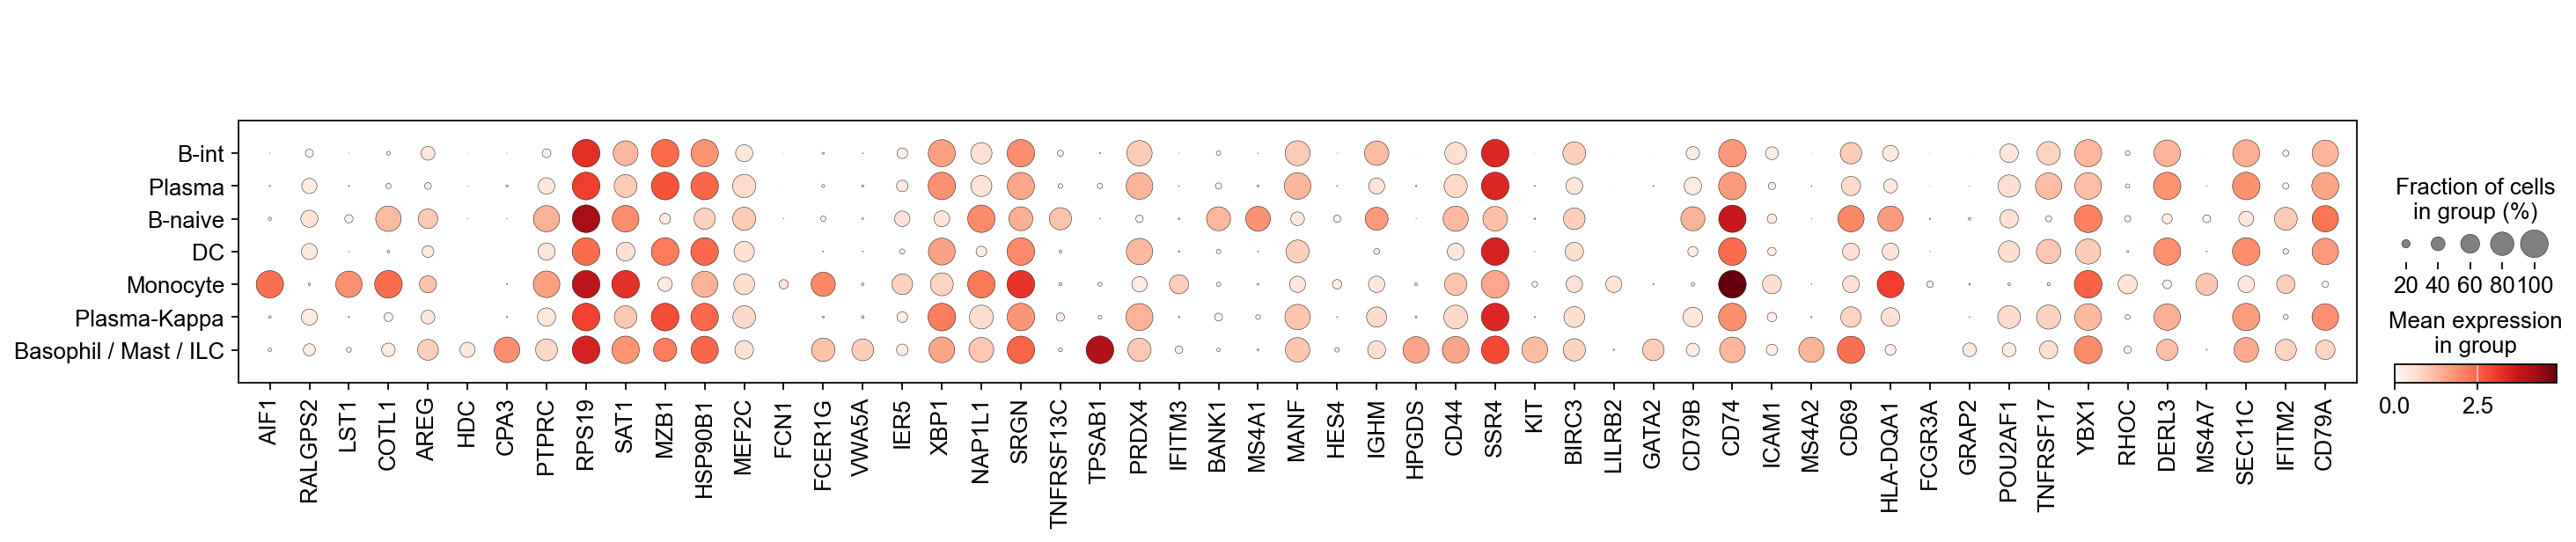

In [73]:
sc.pl.dotplot(
    cca_l_final, 
    [g for g in combined_deg if g in cca_l_final.var_names], 
    groupby='leiden',
)

/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  row_ax = sns.violinplot(
/Users/jgolob/venv/immuno850/lib/python3.11/site-packages/scanpy/plotting/_stacked_violin.py:461: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will 

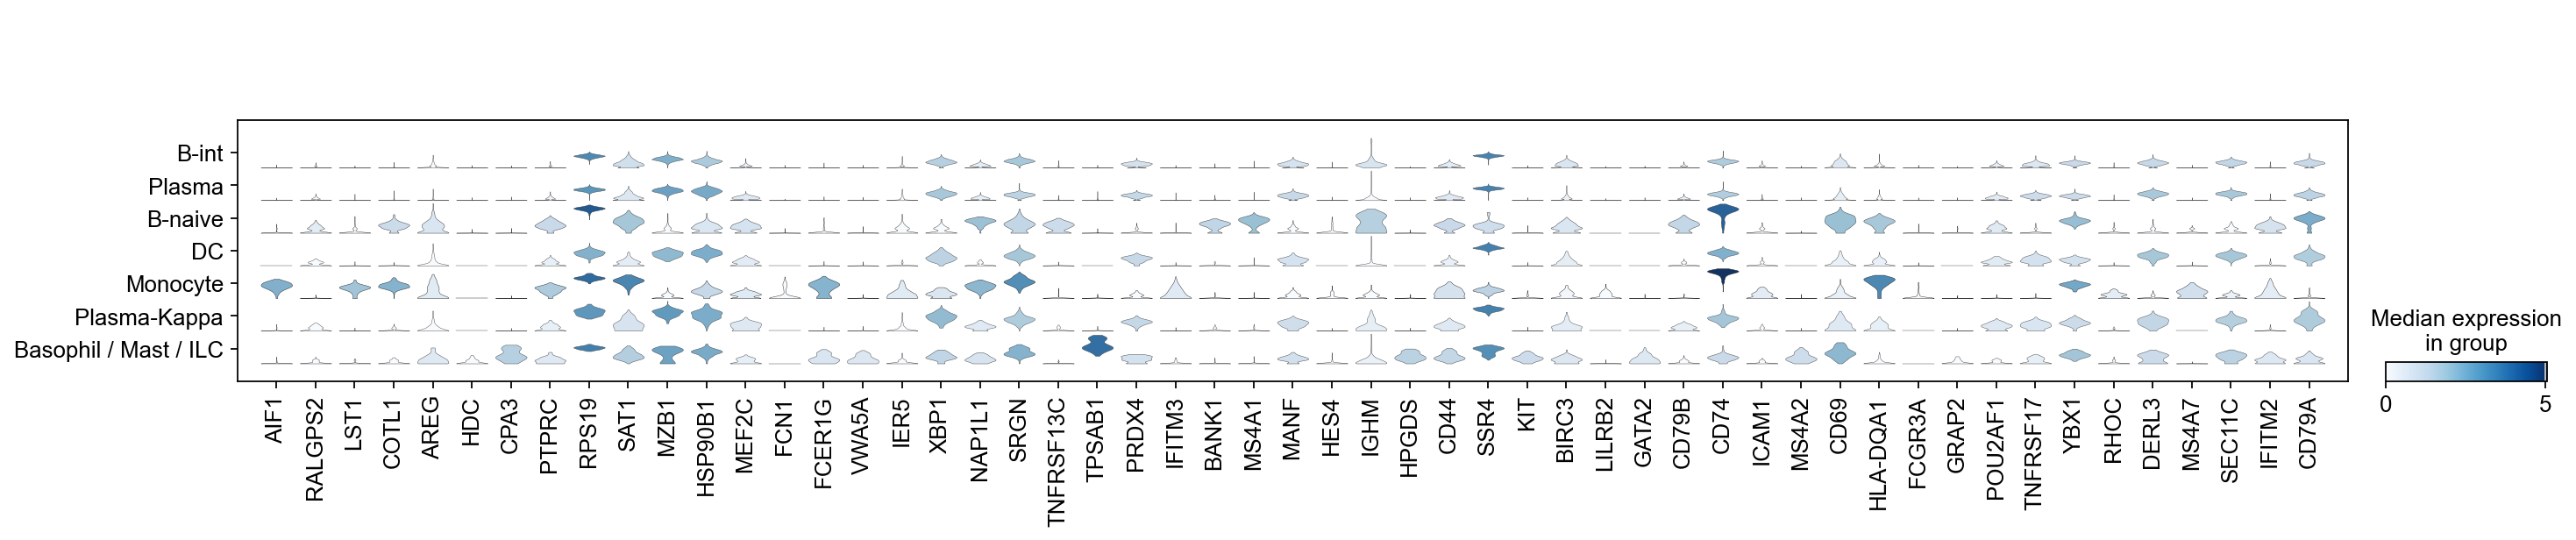

In [74]:
sc.pl.stacked_violin(
    cca_l_final, 
    [g for g in combined_deg if g in cca_l_final.var_names], 
    groupby='leiden',
)

### Saving the results..

Let's save the result as a new anndata object on disk. 
That way we can keep all of our analyses and have something ready for regression analysis, plotting, etc in the future. 

In [75]:
cca_l_final.write_h5ad(
    'data/Colon_cell_atlas.CD45P.clustered.h5ad'
)

## Comparison to 'official' results.

As this is a previously published and analyzed dataset, we can compare our clusters and cell type identifications as to what was published...



In [76]:
official_obs = ad.read_h5ad(
    'data/Colon_cell_atlas.h5ad'
).obs
official_obs.head()

donor  region  n_genes  percent_mito  \
index                                                                  
AAACGGGAGGTGCAAC-1-Pan_T7935487  390c  Caecum     2189      0.016568   
AAAGATGTCCTCAACC-1-Pan_T7935487  390c  Caecum     3199      0.024396   
AAAGTAGTCTTACCGC-1-Pan_T7935487  390c  Caecum     2337      0.023721   
AACCATGCAGATTGCT-1-Pan_T7935487  390c  Caecum     2923      0.020033   
AACCATGTCCTGCCAT-1-Pan_T7935487  390c  Caecum      960      0.035608   

                                 n_counts          cell_type  \
index                                                          
AAACGGGAGGTGCAAC-1-Pan_T7935487   33377.0  B cell IgA Plasma   
AAAGATGTCCTCAACC-1-Pan_T7935487   25783.0  B cell IgA Plasma   
AAAGTAGTCTTACCGC-1-Pan_T7935487   31618.0  B cell IgA Plasma   
AACCATGCAGATTGCT-1-Pan_T7935487   38287.0  B cell IgA Plasma   
AACCATGTCCTGCCAT-1-Pan_T7935487    6403.0  B cell IgA Plasma   

                                BCR_ChainCombination  \
index                                                  
AAACGGGAGGTGCAAC-1-Pan_T7935487            IGH + IGL   
AAAGATGTCCTCAACC-1-Pan_T7935487            IGH + IGK   
AAAGTAGTCTTACCGC-1-Pan_T7935487            IGH + IGL   
AACCATGCAGATTGCT-1-Pan_T7935487            IGH + IGL   
AACCATGTCCTGCCAT-1-Pan_T7935487            IGH + IGK   

                                                        BCR_SEQUENCE_ID  \
index                                                                     
AAACGGGAGGTGCAAC-1-Pan_T7935487  A29_Caecum_AAACGGGAGGTGCAAC-1_contig_2   
AAAGATGTCCTCAACC-1-Pan_T7935487  A29_Caecum_AAAGATGTCCTCAACC-1_contig_2   
AAAGTAGTCTTACCGC-1-Pan_T7935487  A29_Caecum_AAAGTAGTCTTACCGC-1_contig_2   
AACCATGCAGATTGCT-1-Pan_T7935487  A29_Caecum_AACCATGCAGATTGCT-1_contig_2   
AACCATGTCCTGCCAT-1-Pan_T7935487  A29_Caecum_AACCATGTCCTGCCAT-1_contig_2   

                                IGH_V_CALL_GENOTYPED  \
index                                                  
AAACGGGAGGTGCAAC-1-Pan_T7935487          IGHV4-59*01   
AAAGATGTCCTCAACC-1-Pan_T7935487          IGHV3-21*01   
AAAGTAGTCTTACCGC-1-Pan_T7935487          IGHV4-59*01   
AACCATGCAGATTGCT-1-Pan_T7935487        IGHV4-38-2*02   
AACCATGTCCTGCCAT-1-Pan_T7935487          IGHV4-39*01   

                                                         IGH_D_CALL  ...  \
index                                                                ...   
AAACGGGAGGTGCAAC-1-Pan_T7935487                         IGHD6-13*01  ...   
AAAGATGTCCTCAACC-1-Pan_T7935487    IGHD2-2*01,IGHD2-2*02,IGHD2-2*03  ...   
AAAGTAGTCTTACCGC-1-Pan_T7935487               IGHD3-3*01,IGHD3-3*02  ...   
AACCATGCAGATTGCT-1-Pan_T7935487                                 nan  ...   
AACCATGTCCTGCCAT-1-Pan_T7935487  IGHD2-15*01,IGHD3-9*01,IGHD4-11*01  ...   

                                IGL_UMIS TCR_v_gene TCR_d_gene TCR_j_gene  \
index                                                                       
AAACGGGAGGTGCAAC-1-Pan_T7935487  17546.0        nan        nan        nan   
AAAGATGTCCTCAACC-1-Pan_T7935487      NaN        nan        nan        nan   
AAAGTAGTCTTACCGC-1-Pan_T7935487  16972.0        nan        nan        nan   
AACCATGCAGATTGCT-1-Pan_T7935487  11144.0        nan        nan        nan   
AACCATGTCCTGCCAT-1-Pan_T7935487      NaN        nan        nan        nan   

                                TCR_c_gene TCR_cdr3  TCR_cdr3_nt  TCR_reads  \
index                                                                         
AAACGGGAGGTGCAAC-1-Pan_T7935487        nan      nan          nan        NaN   
AAAGATGTCCTCAACC-1-Pan_T7935487        nan      nan          nan        NaN   
AAAGTAGTCTTACCGC-1-Pan_T7935487        nan      nan          nan        NaN   
AACCATGCAGATTGCT-1-Pan_T7935487        nan      nan          nan        NaN   
AACCATGTCCTGCCAT-1-Pan_T7935487        nan      nan          nan        NaN   

                                 TCR_umis  TCR_Clone  
index                                                 
AAACGGGAGGTGCAAC-1-Pan_T79354

In [77]:
cell_id_comparison = pd.merge(
    cca_l_final.obs[['leiden']],
    official_obs[['cell_type']],
    left_index=True,
    right_index=True,
    how='inner'
)
cell_id_comparison

leiden          cell_type
index                                                                 
AAACCTGCAAGGCTCC-1-4861STDY7208411            B-int  B cell IgA Plasma
AAACCTGCACTTCTGC-1-4861STDY7208411            B-int  B cell IgA Plasma
AAACCTGCAGTGGAGT-1-4861STDY7208411            B-int  B cell IgA Plasma
AAACCTGCATGTCTCC-1-4861STDY7208411            B-int  B cell IgA Plasma
AAACGGGAGTGGGCTA-1-4861STDY7208411            B-int  B cell IgA Plasma
...                                             ...                ...
GTGTTAGAGTGATCGG-1-Human_colon_16S8000484     B-int  B cell IgG Plasma
GTTCTCGGTTGAGGTG-1-Human_colon_16S8000484  Monocyte           Monocyte
TACACGACAACTGCGC-1-Human_colon_16S8000484  Monocyte   LYVE1 Macrophage
TCTATTGCATGGTAGG-1-Human_colon_16S8000484   B-naive               Treg
TTCGAAGTCATATCGG-1-Human_colon_16S8000484  Monocyte   LYVE1 Macrophage

[9079 rows x 2 columns]

In [78]:
cell_id_comparison.groupby('leiden').value_counts().reset_index().pivot(
    index='cell_type',
    columns='leiden',
    values='count'
).fillna(0).astype(int)

leiden             B-int  Plasma  B-naive   DC  Monocyte  Plasma-Kappa  \
cell_type                                                                
Activated CD4 T        0       0        0    0         0             0   
B cell IgA Plasma   4210    3856        0  202         0             0   
B cell IgG Plasma     31      36        1    7         0           139   
B cell cycling         1       0        2    0         0             0   
Follicular B cell      0       0       42    0         0             0   
B cell memory          2      10      193    0         0             0   
CD8 T                  0       0       24    0         0             0   
ILC                    0       0       11    0         0             0   
Lymphoid DC            0       3        0    0         0             0   
Monocyte               0       0        0    0        15             0   
Mast                   0       0        0    0         0             0   
Macrophage             0       0        0    0        56             0   
LYVE1 Macrophage       0       0        0    0         6             0   
NK                     0       0        2    0         0             0   
Tcm                    0       0        0    0         0             0   
Tfh                    0       0        0    0         0             0   
Th1                    0       0        0    0         0             0   
Th17                   0       0        1    0         0             0   
Treg                   0       0        4    0         0             0   
cDC1                   0       0        0    0        23             0   
cDC2                   0       0        0    0        72             0   
cycling DCs            0       0        0    0         6             0   
pDC                    0       0        0    0         2             0   
gd T                   0       0        6    0         0             0   
cycling gd T           0       0        4    0         0             0   

leiden             Basophil / Mast / ILC  
cell_type                                 
Activated CD4 T                        0  
B cell IgA Plasma                      4  
B cell IgG Plasma                      0  
B cell cycling                         0  
Follicular B cell                      0  
B cell memory                          0  
CD8 T                                  0  
ILC                                    0  
Lymphoid DC                            0  
Monocyte                               0  
Mast                                 108  
Macrophage                             0  
LYVE1 Macrophage                       0  
NK                                     0  
Tcm                                    0  
Tfh                                    0  
Th1                                    0  
Th17                                   0  
Treg                                   0  
cDC1                                   0  
cDC2                                   0  
cycling DCs                            0  
pDC                                    0  
gd T                                   0  
cycling gd T                           0